## Import functions

In [13]:
import sys
import os
import inspect

# Assuming your scripts directory is one level up from the notebooks directory
sys.path.append(os.path.abspath("../Scripts"))

import importlib
import my_functions as mf
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.stats import gaussian_kde
import autograd.numpy as anp 
import sampyl as smp
from scipy.integrate import odeint
import pandas as pd
import sunode.wrappers.as_pytensor as sun
from my_functions import *
from scipy.integrate import solve_ivp
import pysindy as ps

importlib.reload(mf)
functions_list = inspect.getmembers(mf, inspect.isfunction)
# Print the names of the functions
Fnc_nms = [function[0] for function in functions_list]
Fnc_nms

['Hudson_bay_data',
 'defvjp',
 'estimate_noise_statistics',
 'expand_2D_array',
 'gaussian_process_interpolation',
 'generate_samples',
 'grad_safe_sqrt',
 'load_csv_to_array',
 'mean_squared_error',
 'odeint',
 'plot_kde_matrix',
 'plot_paths',
 'primitive',
 'safe_sqrt',
 'safe_std',
 'save_array_to_csv']

## Load in data and simulate true parameter

(x0)' = 17.659 1 + 0.099 x0 + -1.905 x1
(x1)' = -12.755 1 + 0.638 x0
[[ 17.65887477   0.09865142  -1.90501939   0.           0.
    0.        ]
 [-12.75515522   0.63829439   0.           0.           0.
    0.        ]]


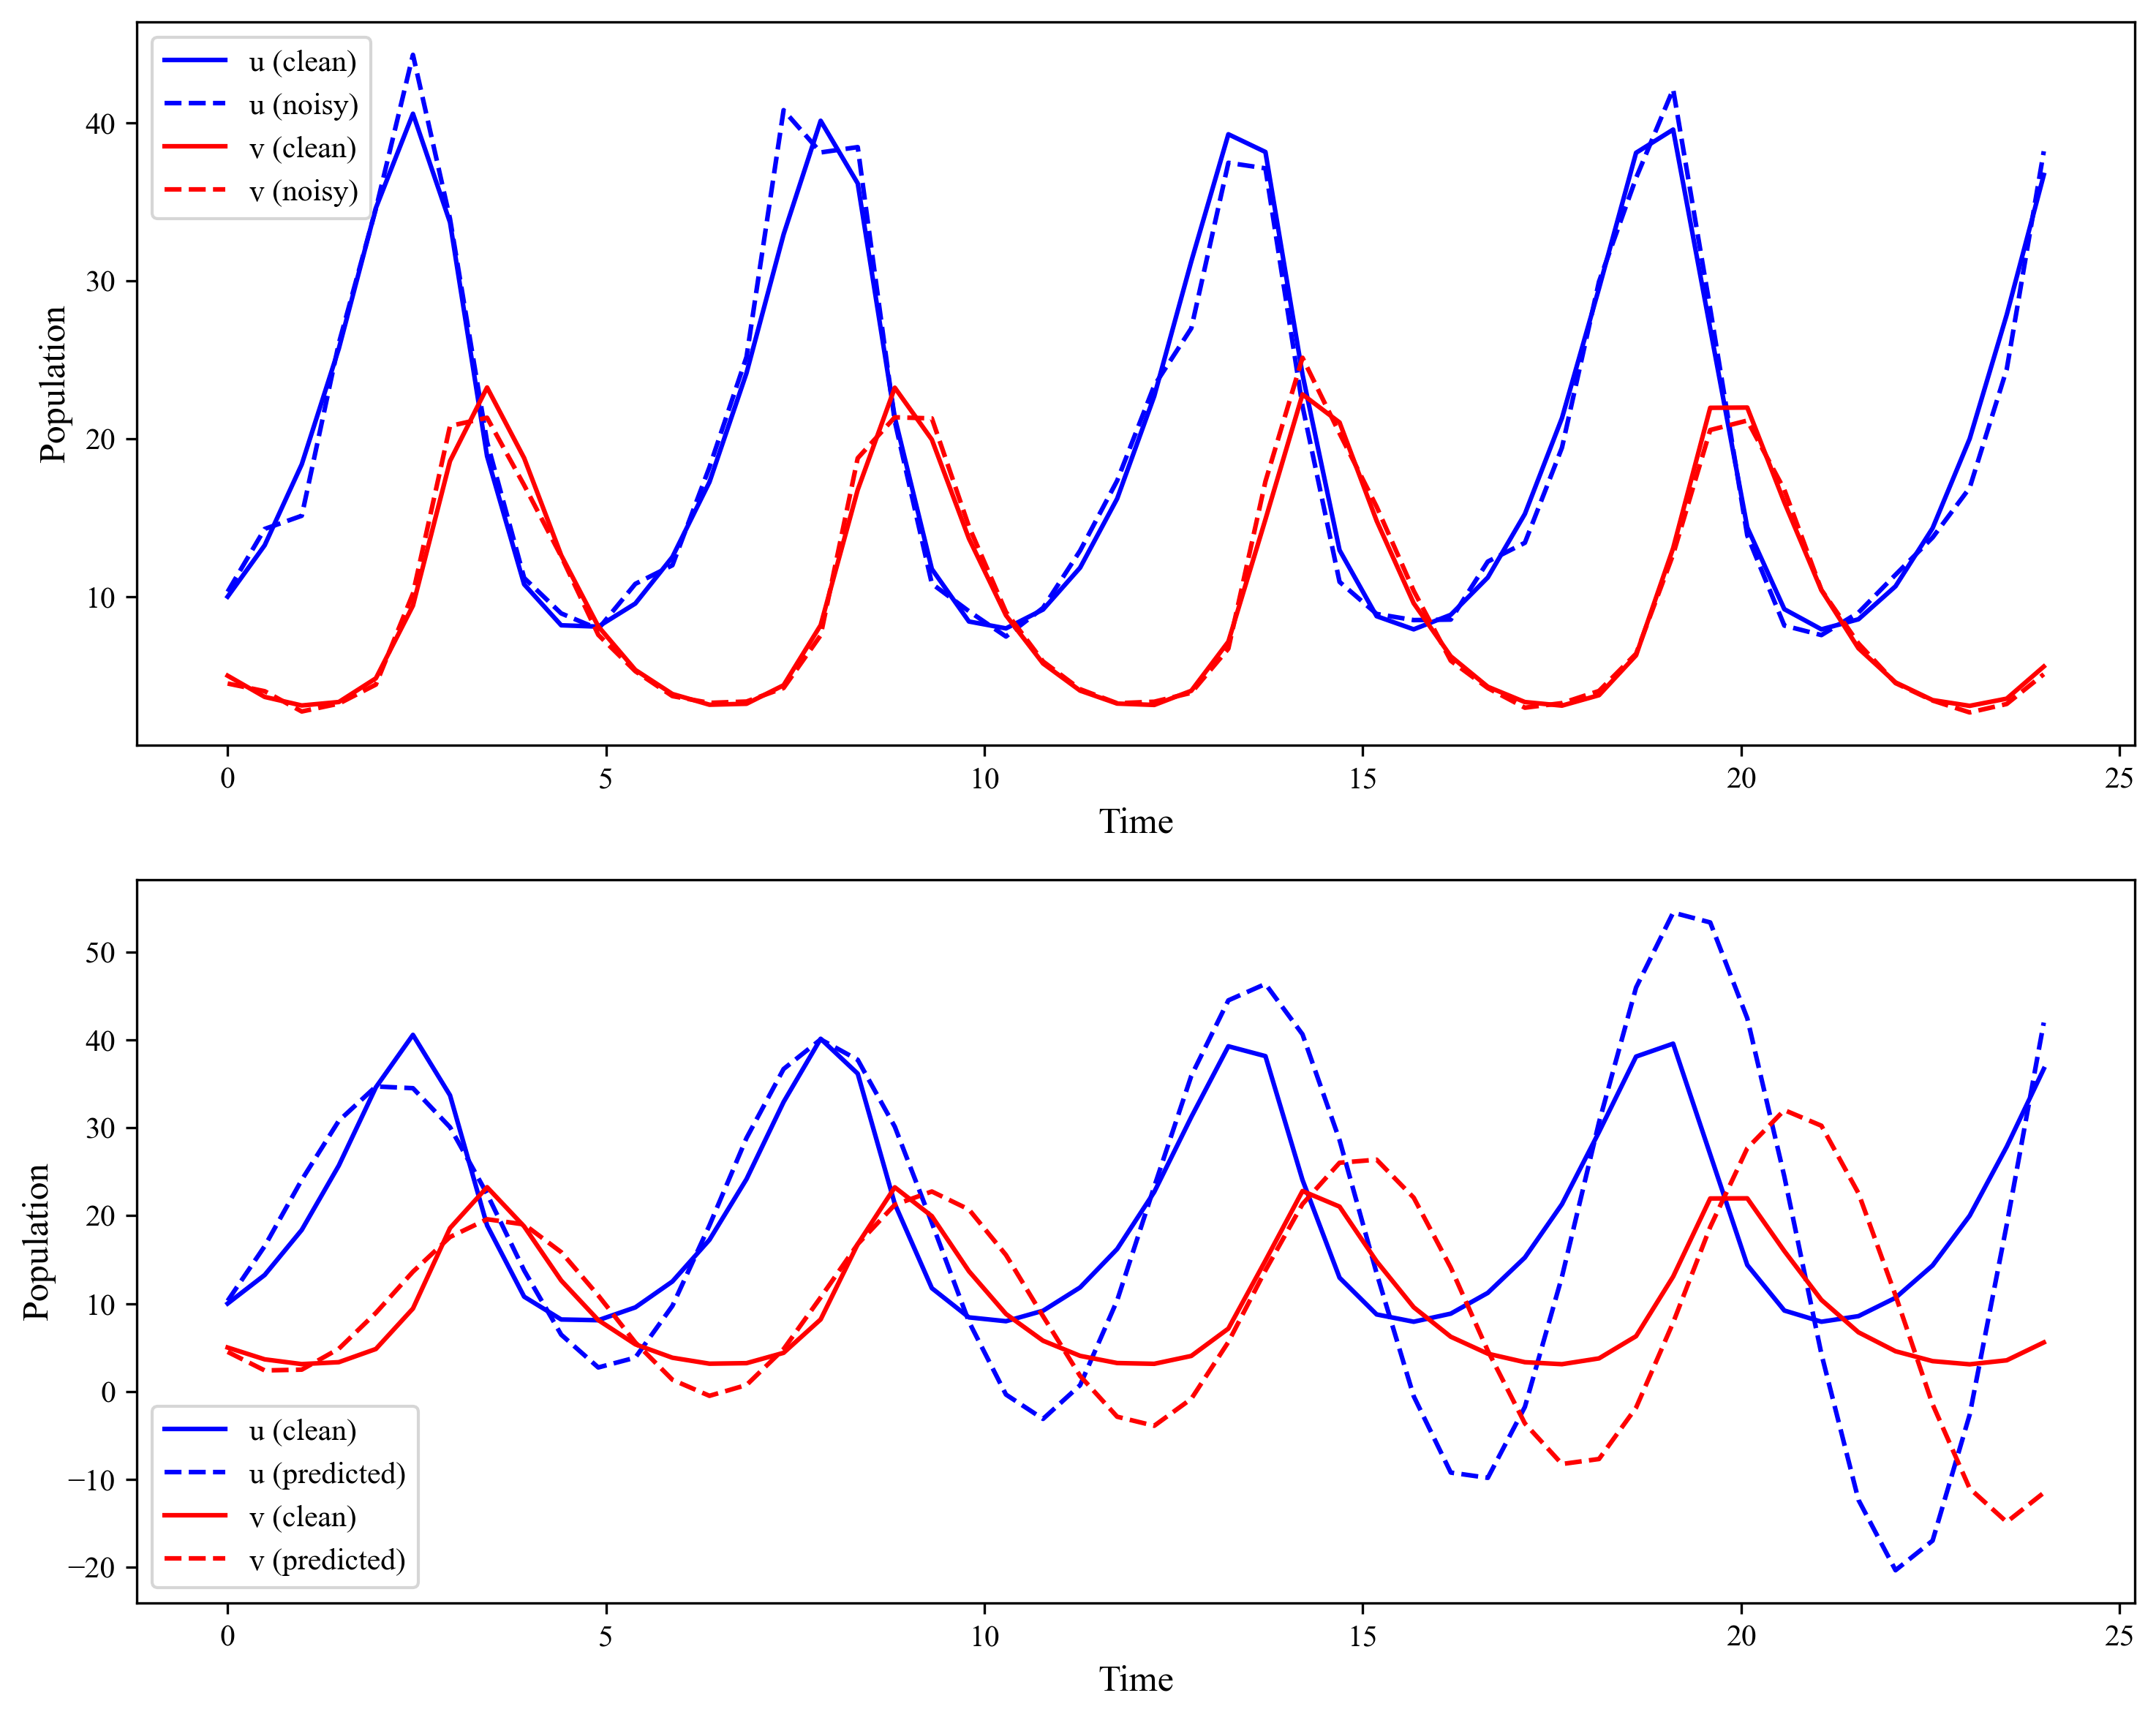

In [65]:
# Parameters
alpha = 1.0
beta = 0.1
gamma = 1.5
delta = 0.075

# Lotka-Volterra model
def lotka_volterra(z, t):
    u, v = z
    du_dt = alpha * u - beta * u * v
    dv_dt = -gamma * v + delta * u * v
    return [du_dt, dv_dt]

# Time points
t = np.linspace(0, 24, 50)

# Initial conditions
z0 = [10, 5]

# Simulate data
x_clean = odeint(lotka_volterra, z0, t)

# Add lognormal multiplicative noise
rng = np.random.default_rng(seed=42)
noise = rng.lognormal(mean=0, sigma=0.1, size=x_clean.shape)
x_noisy = x_clean * noise

# Define the SINDy model with quadratic library
poly_order = 2
library = ps.PolynomialLibrary(degree=poly_order)

# Define the SINDy model with STLSQ optimizer and increased threshold
threshold = 0.1
model = ps.SINDy(optimizer=ps.STLSQ(threshold=threshold),feature_library=library)
model.fit(x_noisy, t=t)
model.print()
print(model.coefficients())

# Plot results
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot clean vs noisy data
axs[0].plot(t, x_clean[:, 0], 'b', label='u (clean)')
axs[0].plot(t, x_noisy[:, 0], 'b--', label='u (noisy)')
axs[0].plot(t, x_clean[:, 1], 'r', label='v (clean)')
axs[0].plot(t, x_noisy[:, 1], 'r--', label='v (noisy)')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Population')
axs[0].legend()

# Predict and plot
x_pred = model.simulate(x_noisy[0], t)
axs[1].plot(t, x_clean[:, 0], 'b', label='u (clean)')
axs[1].plot(t, x_pred[:, 0], 'b--', label='u (predicted)')
axs[1].plot(t, x_clean[:, 1], 'r', label='v (clean)')
axs[1].plot(t, x_pred[:, 1], 'r--', label='v (predicted)')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Population')
axs[1].legend()

plt.tight_layout()
plt.show()


In [73]:
utrue = [980, 980, 2.256*10**(7), 9.61*10**(3)] #[0,1,0,0.1]
vtrue = [0,0,-1.5,0.075]

usindy = [983.3, 979.9, 2.255*10**(7), 9.82*10**(3)]#[17.65887477,  0.09865142,  -1.90501939, 0]
vsindy = [8.21*10**(5), 1.35*10**(6), 2.262*10**(7), 1.227*10**(4)]#[-12.75515522, 0.63829439,   0., 0]

np.sqrt([mf.safe_sqrt(mf.mean_squared_error(utrue, usindy)), mf.safe_sqrt( mf.mean_squared_error(utrue, vsindy))])

array([ 70.71847461, 888.77447365])

In [62]:
calculate_noise_statistics(x_clean, x_noisy)

{'noise_means': array([-0.00181504,  0.03979319]),
 'noise_stds': array([1.91011987, 0.90709215]),
 'noise_percentages': array([9.48611671, 9.6667036 ]),
 'snrs': array([10.54172145, 10.34478806])}

In [56]:
calculate_noise_statistics(x_clean, x_noisy)

{'noise_means': array([-0.00181504,  0.03979319]),
 'noise_stds': array([1.91011987, 0.90709215]),
 'noise_percentages': array([9.48611671, 9.6667036 ]),
 'snrs': array([10.54172145, 10.34478806])}

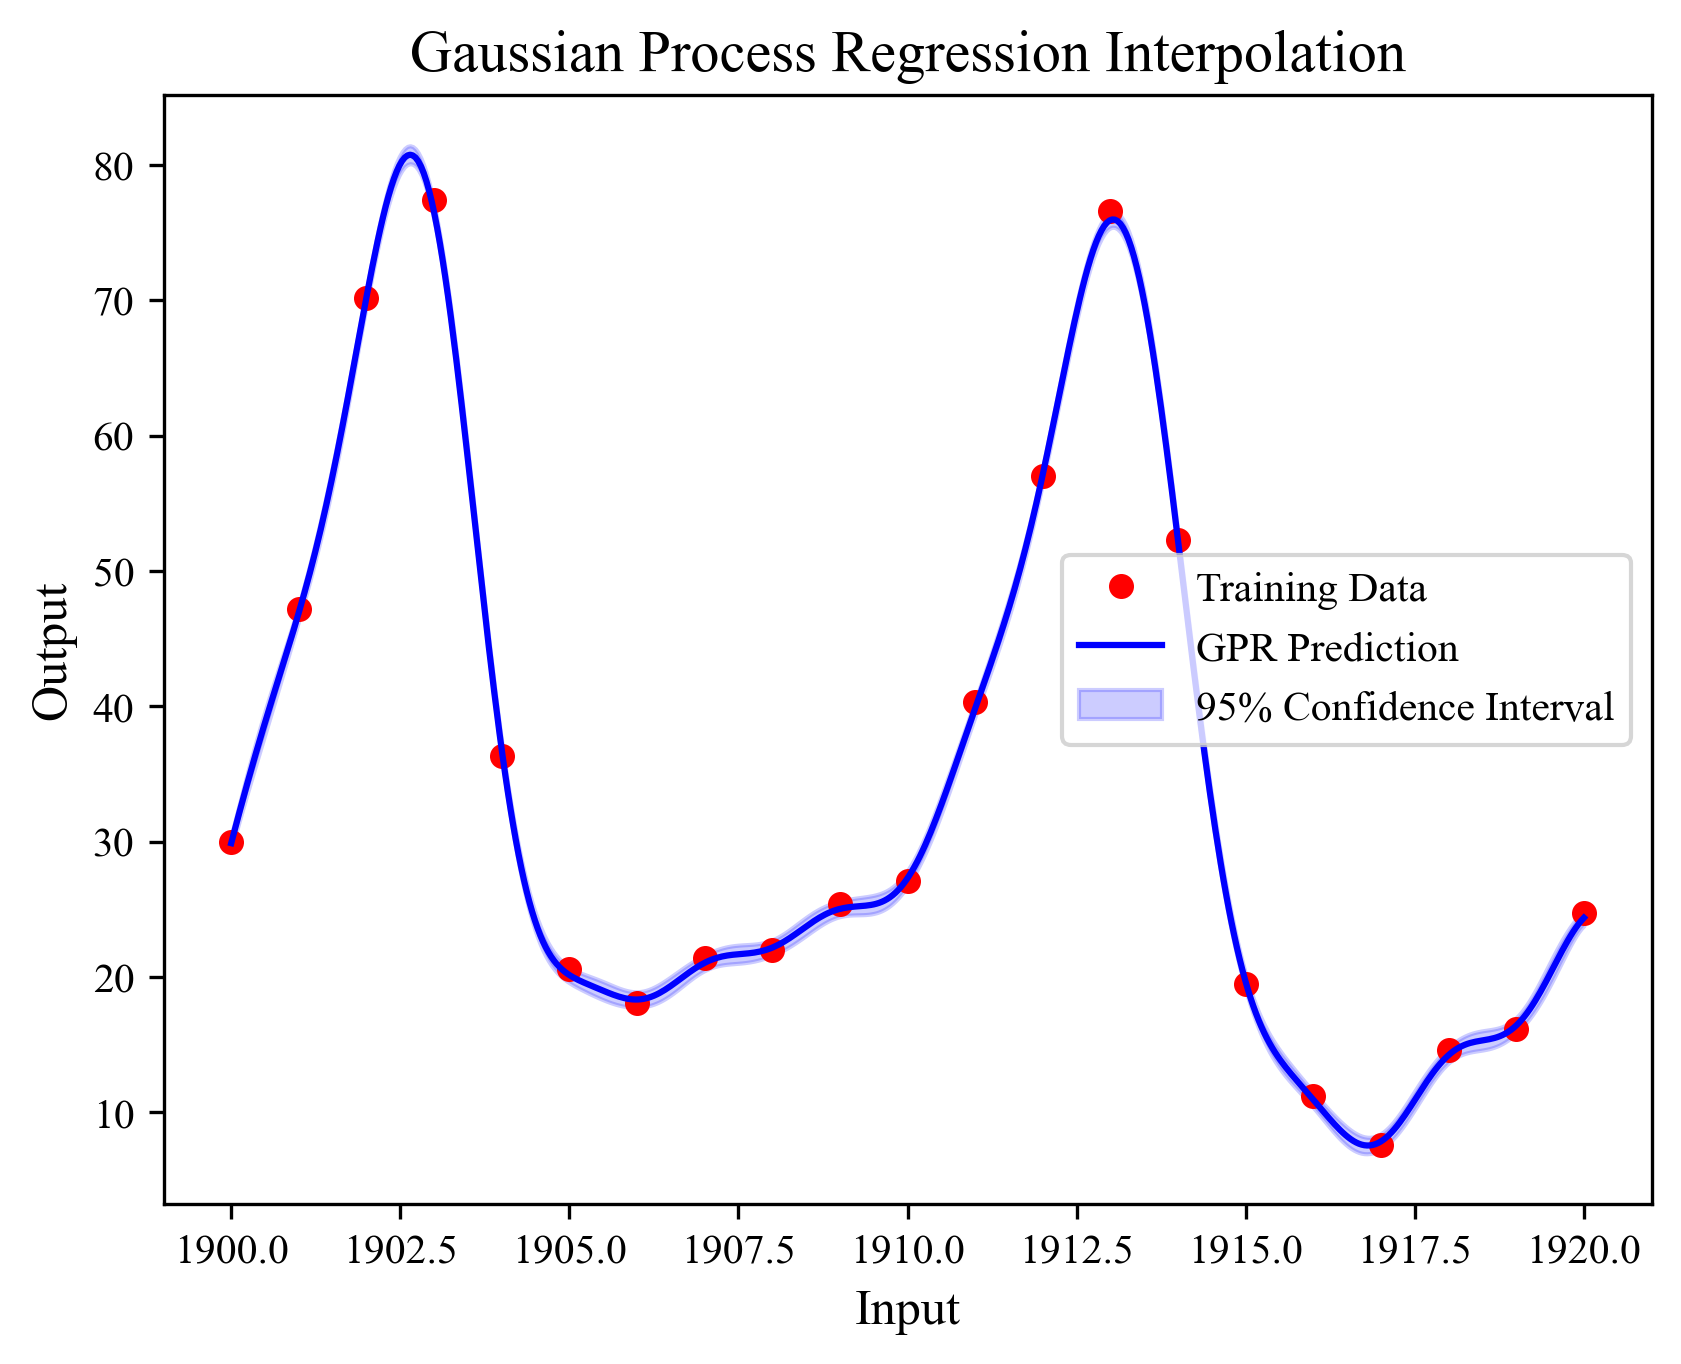

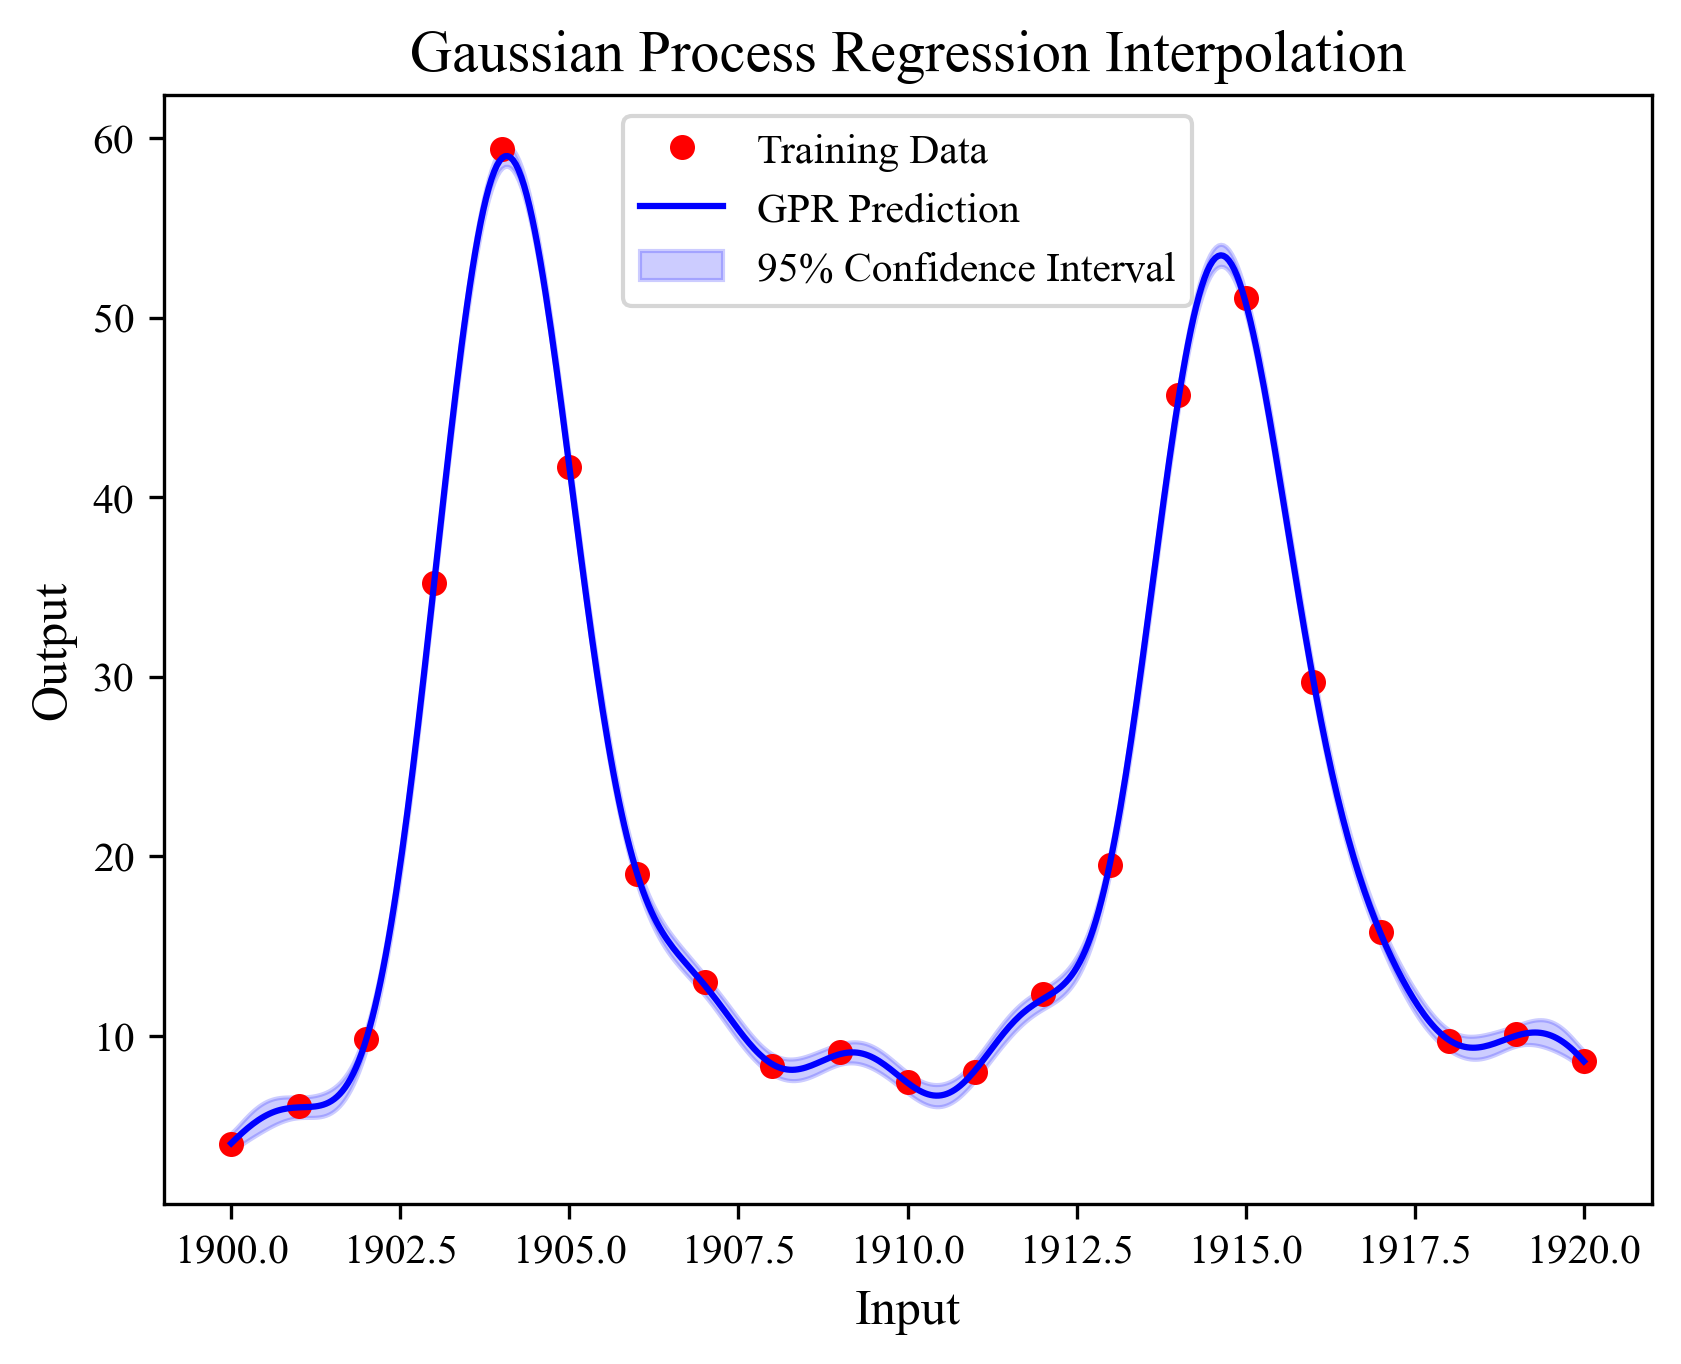

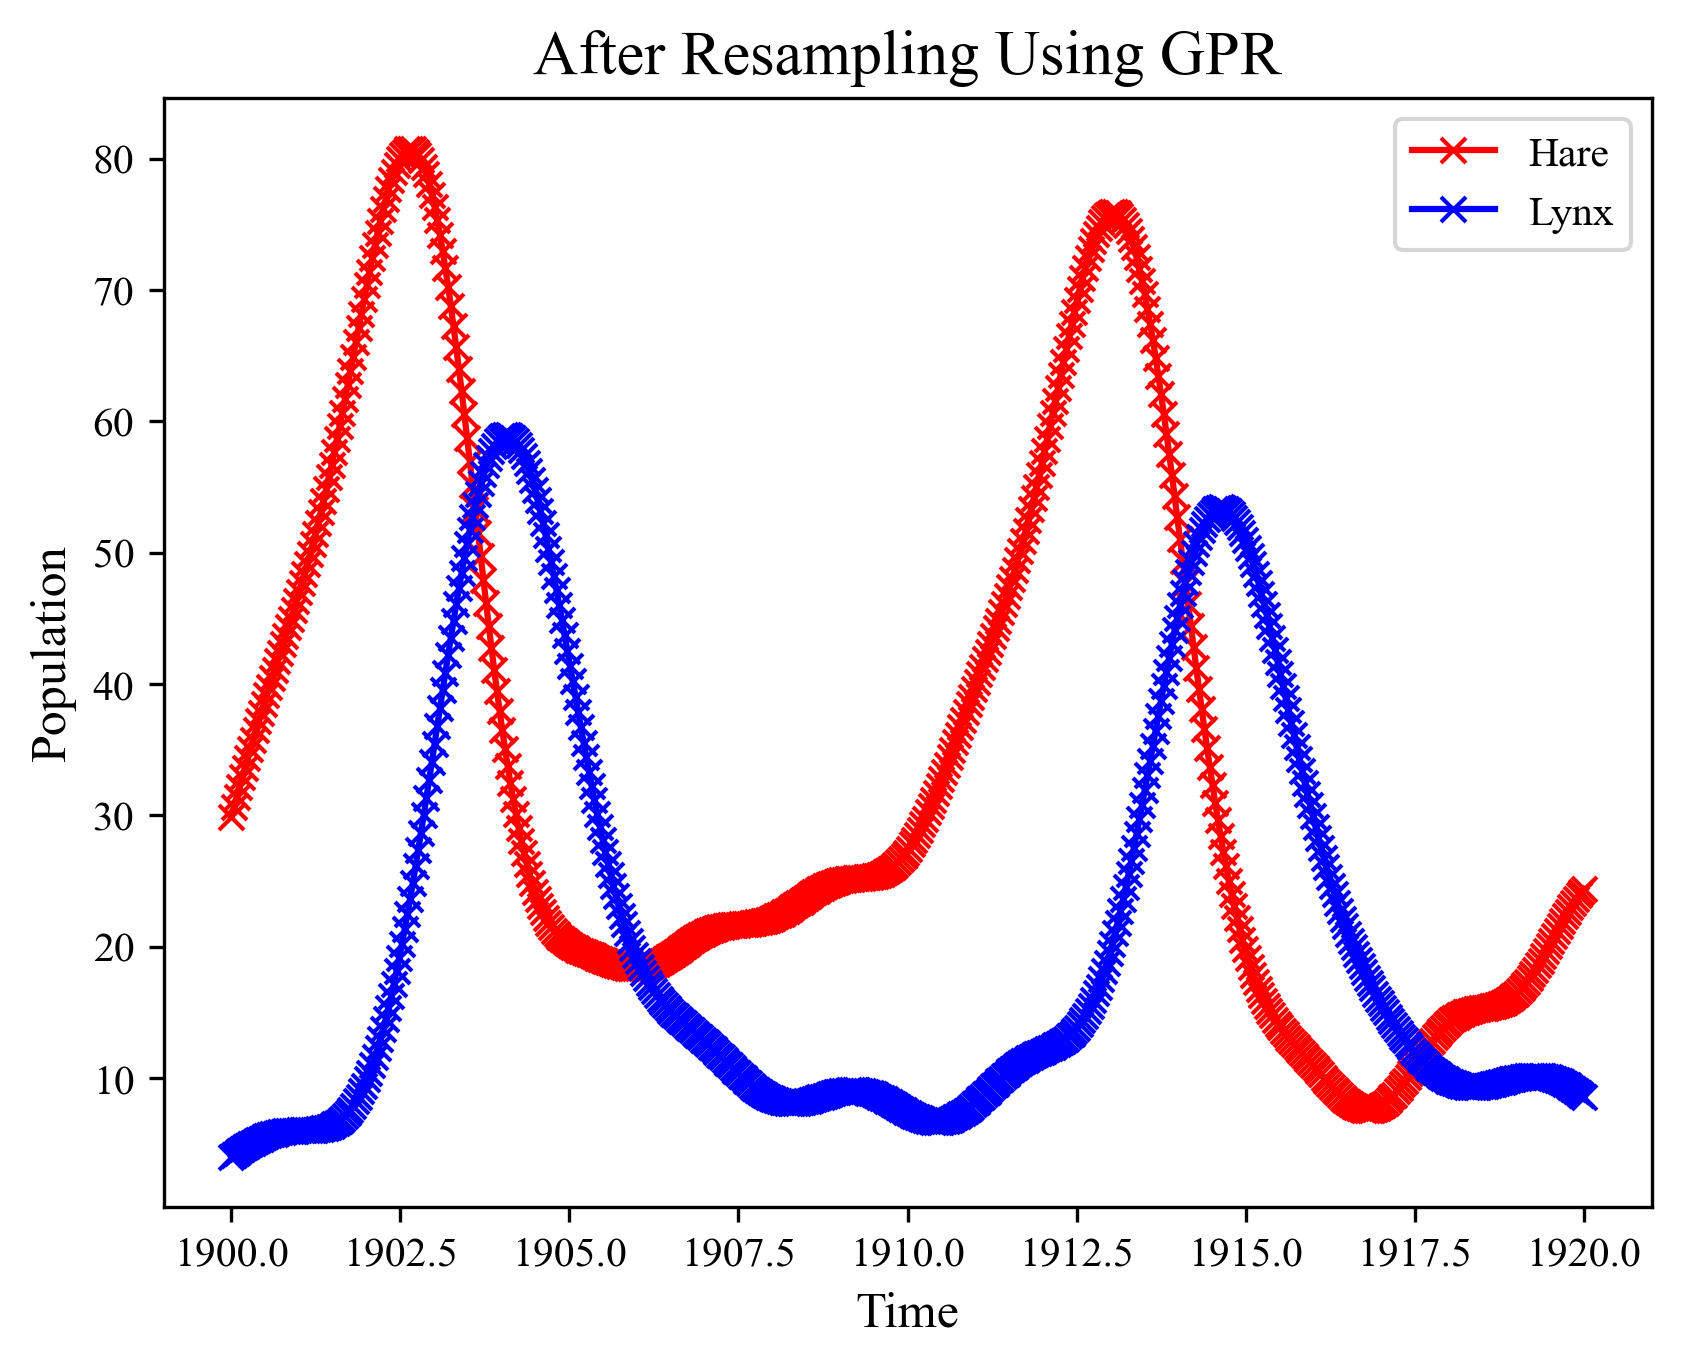

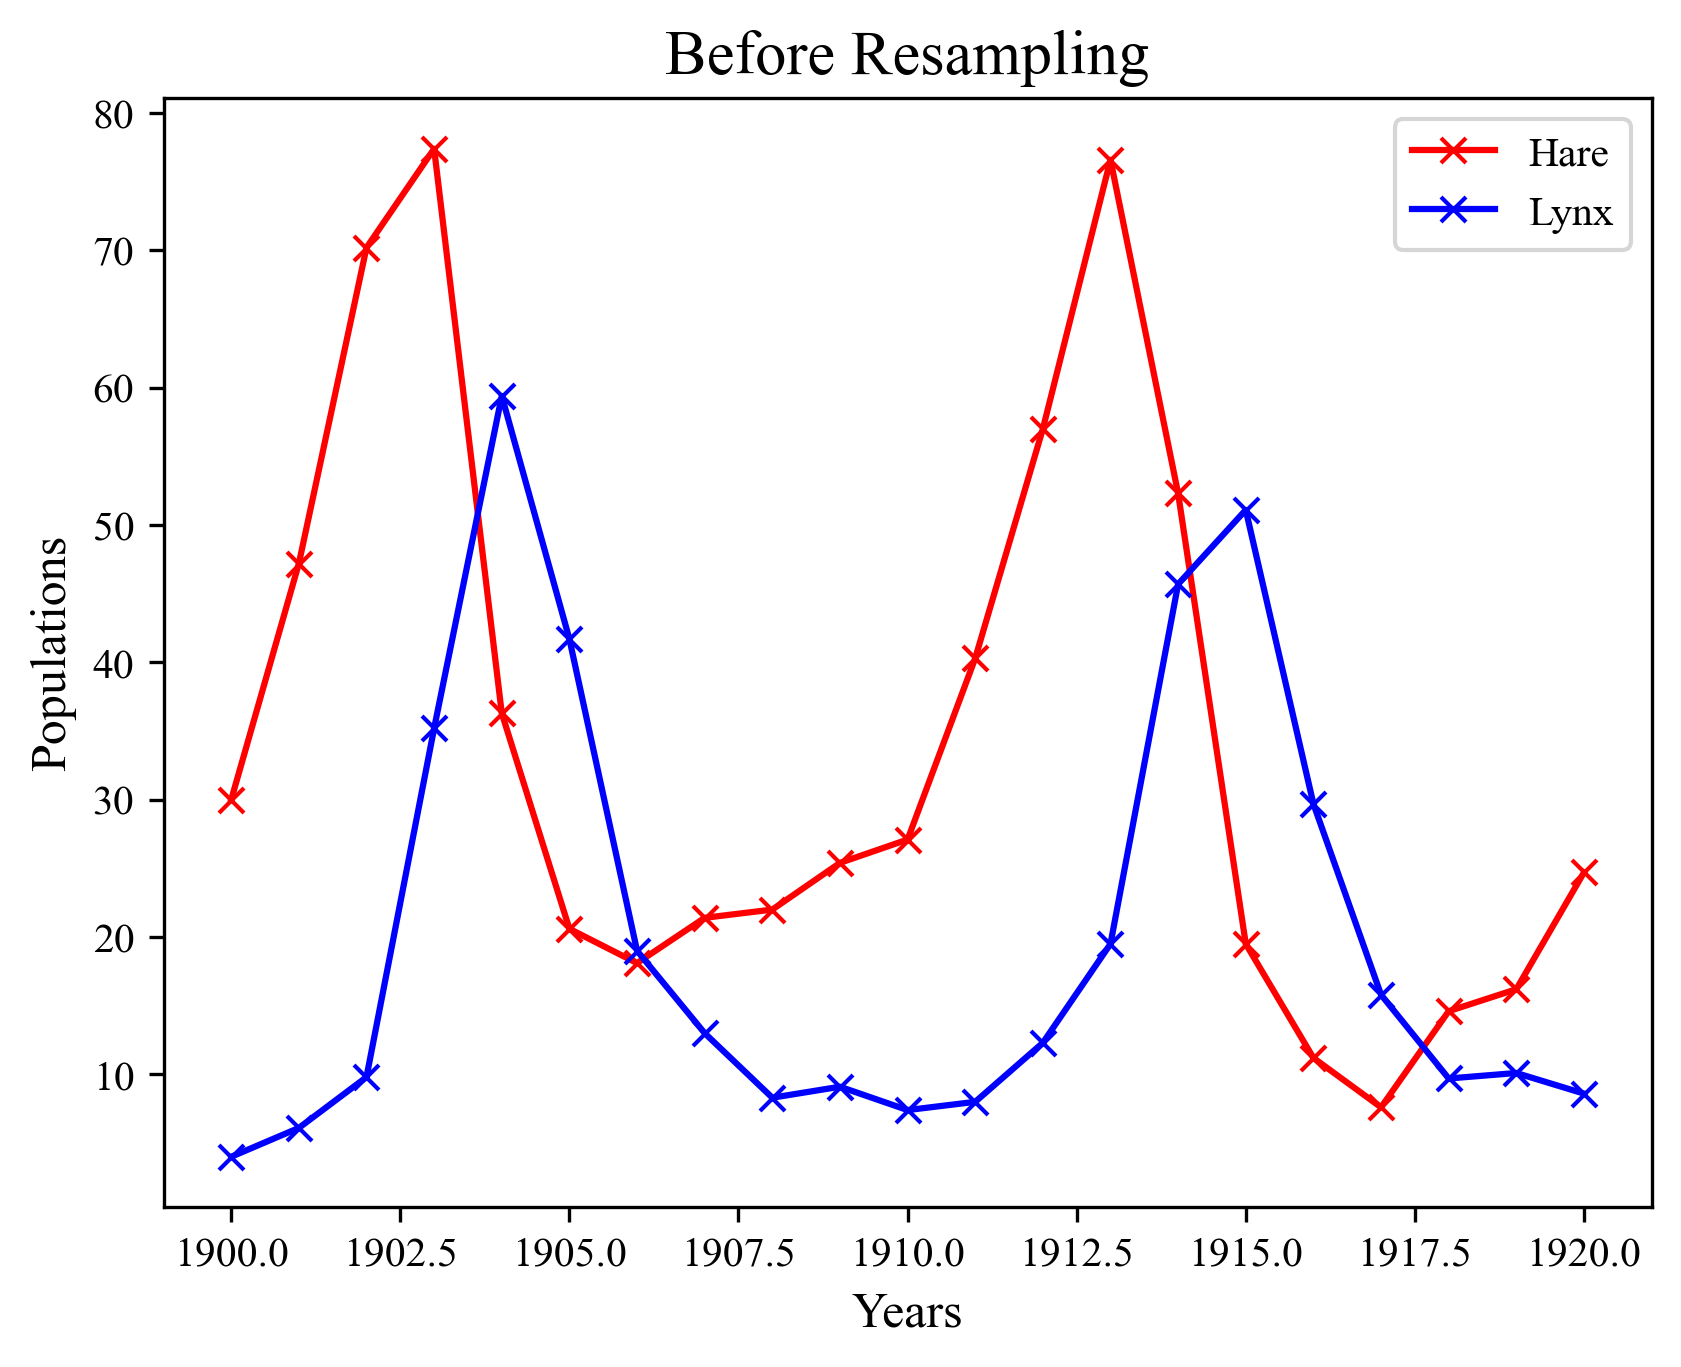

In [34]:
# Load actual data from function
hare, lynx, u_scale, v_scale, years_ = mf.Hudson_bay_data(False)   

#Upsample data using gaussian process regression
num_points = 500
alpha = 0.3
years_new, hare_new = gaussian_process_interpolation(years_, hare, num_points,  noise_level=alpha)
years_new, lynx_new = gaussian_process_interpolation(years_, lynx, num_points,  noise_level=alpha)
years = years_new.reshape(-1)

# Prepare data for learning ease
u_data =  np.array(hare_new).reshape(-1)
v_data = np.array(lynx_new).reshape(-1)
v_data = np.array(lynx_new)
u_scale = np.std(u_data)
v_scale = np.std(v_data)

#scale data for learning purpose
u_norm = u_data/u_scale
v_norm = v_data/v_scale


# Plot scaled data
plt.figure()
plt.title('After Resampling Using GPR', fontsize = 15)
plt.plot(years, u_data,'r-x', label='Hare')
plt.plot(years, v_data, 'b-x',label='Lynx')

plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

#plot actual data
plt.title('Before Resampling', fontsize = 15)
plt.plot(years_, hare, 'r-x',label = 'Hare')
plt.plot(years_, lynx, 'b-x',label = 'Lynx')
plt.legend()
plt.xlabel(f'Years')
plt.ylabel(f'Populations')
plt.show()

### Simulate test functions

In [102]:
# Lotka-Volterra model equations
def lotka_volterra_system(state, t, alpha, beta, delta, gamma):
    x, y = state
    dx_dt = alpha * x + beta * x * y
    dy_dt = delta * x * y + gamma * y
    return [dx_dt, dy_dt]

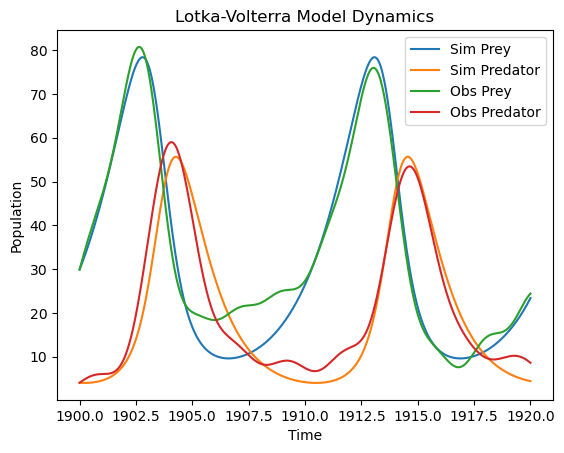

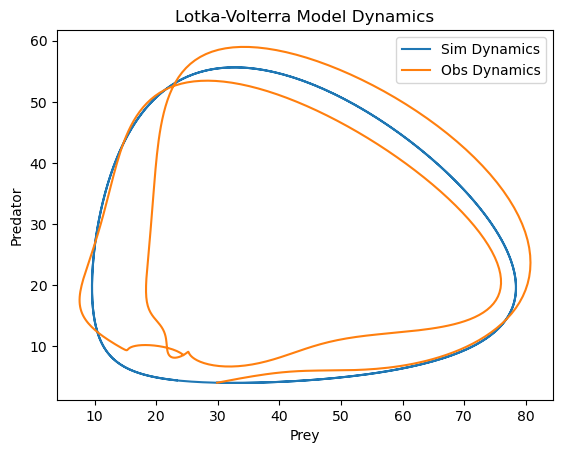

In [103]:
#General parameters
num_points = len(years)

# simulation Parameters
alpha = 0.55
beta = -0.455
delta = 0.5433
gamma = -0.84
params = (alpha, beta, delta, gamma)

# params = (0.39396811, -0.01850895,  0.0156399, -0.53858506)
# params = (0.42299561, -0.01941126,  0.01715028, -0.60961939)

# Initial conditions
u0 = u_norm[0] #1.324 
v0 = v_norm[0] #0.273
initial_state = [u0, v0] #[27.67, 4.43]#

# Time points
time = np.array(years,dtype=float)
t = time

# Solve ODE
solution = odeint(lotka_volterra_system, initial_state, time, args=params)
u_sim, v_sim = solution.T
u_sim,v_sim = u_sim*u_scale, v_sim*v_scale    

# plot and compare simulation versus observed data
plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
plt.plot(t, u_sim, label='Sim Prey')
plt.plot(t, v_sim, label='Sim Predator')
plt.plot(t, u_data, label='Obs Prey')
plt.plot(t, v_data, label='Obs Predator')

plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
plt.plot(u_sim, v_sim, label='Sim Dynamics')
plt.plot(u_data, v_data, label='Obs Dynamics')

plt.xlabel('Prey')
plt.ylabel('Predator')
plt.legend()
plt.show()

### Agnostic Learning functions

In [104]:
def generate_library(x,y):
    x= np.array(x)
    y = np.array(y)
    lib_mat = np.array([np.ones(len(x)), x, y, x*y]).T
    return lib_mat

def simulate_param(params, library):
    params = np.array(params).reshape(-1,1)
    return np.dot(library, params).reshape(-1)

def integrate_x_dot(x_dot, t, init_val):
    """
    Integrates x_dot with respect to time t using the cumulative trapezoidal rule.

    Parameters:
    - x_dot: Array of derivative values with respect to time (velocity if x is position).
    - t: Array of time values.

    Returns:
    - x: Array of integrated values (position if x_dot is velocity), same length as t by adding initial condition.
    """
    # Compute the cumulative integral of x_dot with respect to t
    x = cumulative_trapezoid(x_dot, t, initial=0)+init_val  # Set initial=0 to include the starting point in the result array

    return x

def numerate_param(param, library, init_val, t=t):
    z_dot = simulate_param(param, library)
    z_intgrt = integrate_x_dot(z_dot, t, init_val)
    return z_intgrt

import pysindy as ps
# differentiation function
def differentiate(data,time, wl = 5, order = 3):
    smoothed_fd = ps.SmoothedFiniteDifference(order=order, smoother_kws={'window_length': wl})
    dldt = smoothed_fd(data,time)
    d2ldt = smoothed_fd(dldt, time)
    d3ldt = smoothed_fd(d2ldt, time)
    return [dldt,d2ldt,d3ldt] 

MSE value = (0.05510755288860046, 0.08524886708945777)


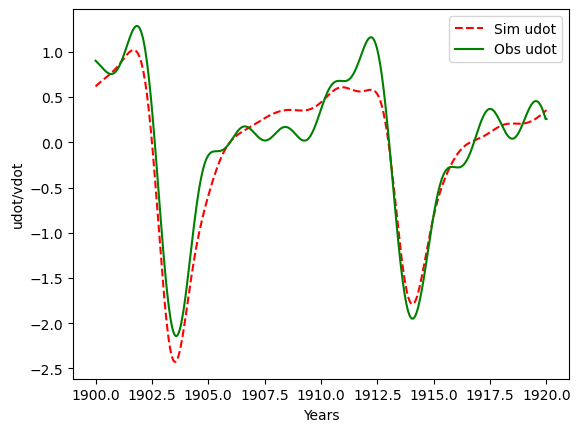

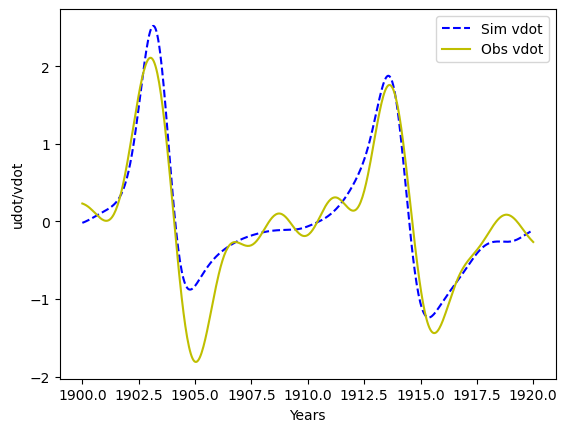

In [105]:
# Generate library data
library = generate_library(u_norm, v_norm)

# Define true parameters
u_param_true = [0,0.55,0,-0.455]
v_param_true = [0,0,-0.84,0.5433]

# Simulate x_dot and v_dot
u_dot_true = simulate_param(u_param_true, library)
v_dot_true = simulate_param(v_param_true, library)

u_dot_noisy =  differentiate(u_norm, time, wl = 13, order=1)[0]
v_dot_noisy = differentiate(v_norm, time, wl = 11, order=2)[0]

# compute the mse value
u_mse =  mean_squared_error(u_dot_true,u_dot_noisy)
v_mse =  mean_squared_error(v_dot_true,v_dot_noisy)
print(f'MSE value = {u_mse, v_mse}')

# plot the numerical differentiation and predicted
plt.plot(t, u_dot_true, 'r--', label = 'Sim udot')
plt.plot(t, u_dot_noisy, 'g', label = 'Obs udot')
plt.legend()
plt.xlabel(f'Years')
plt.ylabel(f'udot/vdot')
plt.show()


plt.plot(t, v_dot_true, 'b--', label = 'Sim vdot')
plt.plot(t, v_dot_noisy, 'y', label = 'Obs vdot')
plt.legend()
plt.xlabel(f'Years')
plt.ylabel(f'udot/vdot')
plt.show()

## SIP Learning

In [106]:
import numpy as np
from sklearn.utils import resample
from scipy.interpolate import interp1d
from sklearn.neighbors import KernelDensity
from scipy.stats import entropy
from scipy.integrate import cumulative_trapezoid

In [108]:
def equally_spaced_elements(n, array):
    # Get the length of the input array (considering 1D or 2D cases)
    p = array.shape[-1]  # This works for both 1D and 2D arrays
    # Ensure p > n
    if p <= n:
        raise ValueError("The length of the array must be greater than n.")
    # Create a new array with n equally spaced values from 0 to p-1
    indices = np.linspace(0, p-1, n, dtype=int)
    # Reshape the array if it's 1D
    if array.ndim == 1:
        array = array.reshape(1, -1)
    # Check if indices are within bounds of the array's columns
    if np.any(indices >= array.shape[1]):
        raise ValueError("Some indices are out of bounds for the given array.")
    # Extract elements based on the provided indices
    extracted_elements = array[:, indices]
    return extracted_elements, indices

def estimate_kde(y_paths, bw_method='scott', dim=5, idx = False):
    """Estimates a kernel density estimate (KDE) for a given 2D array of observations where each row is a random variable."""
    data, indices =  equally_spaced_elements(dim, y_paths) #y_paths[:,:dim]
    print("Data shape for KDE:", data.shape)
    kde = KernelDensity(bandwidth=bw_method, kernel='gaussian')
    kde.fit(data)
    if idx:
        return kde, indices
    else:
        return kde

def kde_density_at_points(kde, points, dim=5):
    """Evaluates the density of the previously estimated KDE at specified points."""
    eval_points, indices = equally_spaced_elements(dim, points) #points[:,:dim]
    # Evaluate the log density at these points
    log_densities = kde.score_samples(eval_points)
    # Convert log densities to densities
    densities = np.exp(log_densities)    
    return densities

def rejection_sampling(samples_from_prior, Q, kde_obs, kde_prior, *args ):
    """Perform rejection sampling to generate samples from the posterior"""
    # Calculate r(Q(lambda)) for each sample from the prior
    def r(prior, Q=Q, kde_obs=kde_obs, kde_prior=kde_prior):
        push_prior = Q(prior, *args)
        kde_obs_pprior = kde_density_at_points(kde_obs, push_prior, dim=dim)
        kde_prior_pprior = kde_density_at_points(kde_prior, push_prior, dim=dim)
        return kde_obs_pprior/kde_prior_pprior
    r_values = r(samples_from_prior) #np.array([r(sample) for sample in samples_from_prior])
    
    # Find the maximum value of r(Q(lambda)) to use as M
    M = np.max(r_values)
    
    accepted_samples = []
    accepted_probs = []
    for i, lambda_p in enumerate(samples_from_prior):
        # Use the precomputed r_values
        r_Q_lambda = r_values[i]
        
        # Generate a random number from a uniform distribution on [0, 1]
        epsilon_p = np.random.uniform(0, 1)
        
        # Compute the ratio
        ratio_p = r_Q_lambda / M
        
        # Accept or reject the sample based on the ratio
        if ratio_p >= epsilon_p:
            accepted_samples.append(lambda_p) 
            accepted_probs.append(ratio_p)
            print(f'prob-value = {ratio_p}, accepted value = {lambda_p}\n')
    print(f'{len(accepted_samples)} was accepted out of {len(samples_from_prior)} total prior samples')
    return np.array(accepted_samples)

def kl_divergence(p, q, bandwidth=1.0):
    """ Calculate the KL divergence between two KDEs of multivariate datasets p and q.  """
    # Fit KDE to both datasets
    kde_p = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(p)
    kde_q = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(q)

    # Sample points from KDEs (using the fitted model's 'sample' method) for evaluation
    # Note: This is an approximation to avoid the integration over the entire space
    points = kde_p.sample(n_samples=200)  # Number of samples to approximate the integration

    # Evaluate log probability density of points under both KDEs
    log_p_x = kde_p.score_samples(points)
    log_q_x = kde_q.score_samples(points)

    # Calculate the KL divergence using the log probabilities
    kl_p_q = np.sum(np.exp(log_p_x) * (log_p_x - log_q_x)) / points.shape[0]
    kl_q_p = np.sum(np.exp(log_q_x) * (log_q_x - log_p_x)) / points.shape[0]
    return kl_p_q, kl_q_p

def bootstrap_lotka_volterra(data):
    """
    Bootstraps the Lotka-Volterra predator-prey population data.
    """
    n = data.shape[1]  # Number of time instances
    indices = np.arange(1, n - 1)  # Create index array from 1 to n-1
    
    # Bootstrap sample indices (without replacement, 65% of original)
    boot_indices = resample(indices, replace=False, n_samples=int(0.6 * len(indices)))#, random_state=42)
    boot_indices = np.sort(boot_indices)  # Sort indices for slicing
    
    # Add the first and last index
    boot_indices = np.insert(boot_indices, 0, 0)  # Add index 0 at the start
    boot_indices = np.append(boot_indices, n - 1)  # Add index n-1 at the end
    
    # Extract corresponding predator and prey populations
    prey_sampled = data[0, boot_indices]
    predator_sampled = data[1, boot_indices]
    
    # Create new time points to interpolate to (original number of points)
    new_time_points = np.linspace(0, n - 1, n)
    
    # Interpolate sampled data to new time points
    interpolate_prey = interp1d(boot_indices, prey_sampled, kind='linear', fill_value="extrapolate")
    interpolate_predator = interp1d(boot_indices, predator_sampled, kind='linear', fill_value="extrapolate")
    
    # Generate new interpolated data
    new_prey_population = interpolate_prey(new_time_points)
    new_predator_population = interpolate_predator(new_time_points)
    
    return new_prey_population, new_predator_population

def generate_population_of_paths(prey_population, predator_population, samples=100):
    """
    Generates a population of bootstrapped paths from a single predator-prey path.
    """
    # Stack the populations into a 2xN array as required
    data = np.vstack([prey_population, predator_population])
    
    # Generate multiple bootstrap samples
    bootstrapped_samples = [bootstrap_lotka_volterra(data) for _ in range(samples)]
    return np.array(bootstrapped_samples)

### Prepare data

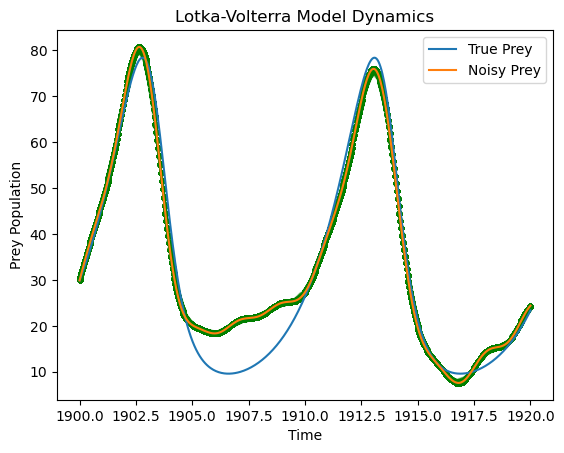

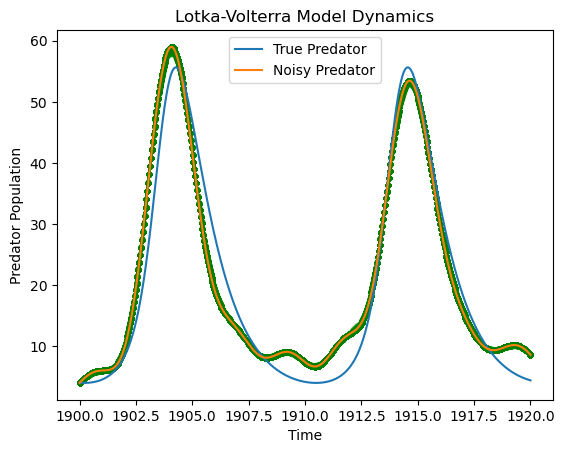

In [109]:
# Generate bootstrapped data paths for the analysis

bootstrapped_samples = generate_population_of_paths(u_data, v_data, samples=500)
x_noisy_paths = bootstrapped_samples[:,0]
y_noisy_paths =  bootstrapped_samples[:,1]


# Visualize paths
plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
for xn in x_noisy_paths:
    plt.plot(t, xn, 'g.-', alpha = 0.3)
plt.plot(t, u_sim, label='True Prey')
plt.plot(t, u_data, label='Noisy Prey')
plt.xlabel('Time')
plt.ylabel('Prey Population')
plt.legend()
plt.show()

plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
for yn in y_noisy_paths:
    plt.plot(t, yn, 'g.-', alpha = 0.3)

plt.plot(t, v_sim, label='True Predator')
plt.plot(t, v_data, label='Noisy Predator')
plt.xlabel('Time')
plt.ylabel('Predator Population')
plt.legend()
plt.show()

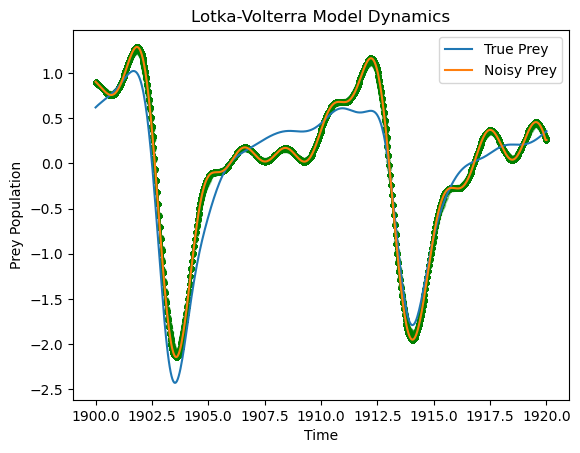

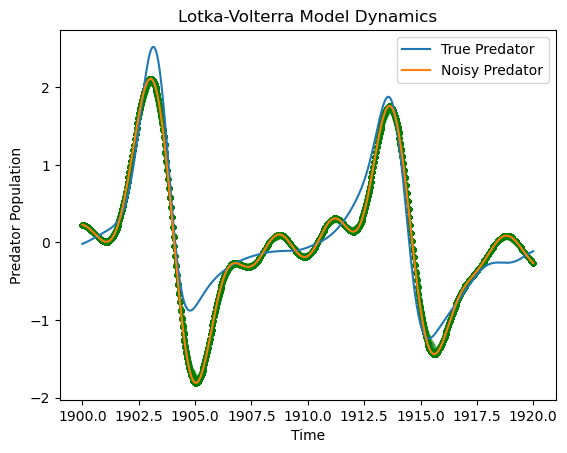

In [110]:
# Generate bootstrapped data (derivatives) paths for the analysis
x_dot_noisy, y_dot_noisy = u_dot_noisy, v_dot_noisy
bootstrapped_samples = generate_population_of_paths(x_dot_noisy, y_dot_noisy, samples=300)
x_noisy_paths = bootstrapped_samples[:,0]
y_noisy_paths =  bootstrapped_samples[:,1]


# Visualize paths
plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
for xn in x_noisy_paths:
    plt.plot(t, xn, 'g.-', alpha = 0.3)
plt.plot(t, u_dot_true, label='True Prey')
plt.plot(t, x_dot_noisy, label='Noisy Prey')
plt.xlabel('Time')
plt.ylabel('Prey Population')
plt.legend()
plt.show()

plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
for yn in y_noisy_paths:
    plt.plot(t, yn, 'g.-', alpha = 0.3)

plt.plot(t, v_dot_true, label='True Predator')
plt.plot(t, y_dot_noisy, label='Noisy Predator')
plt.xlabel('Time')
plt.ylabel('Predator Population')
plt.legend()
plt.show()

### Begin analysis

In [113]:
def gofx(prior_param_samples, library):
    pushforward = [simulate_param(param, library) for param in prior_param_samples]
    return np.array(pushforward)

def ss_prior_fn(prior, spike_prob):
    if len(spike_prob) == prior.shape[-1]:
        spike_indicator = np.random.binomial(1, 1 - spike_prob, size=prior.shape)
        new_prior = spike_indicator * prior
    else:
        print(f'Length of spike probability does not match number of data columns')
        return None  # or you can raise an exception
    return new_prior

# Example usage
spike_prob=np.array([0.7,0.1,0.7,0.1])
prior_tmp = np.array([1,2,3,4])
# ss_prior_fn(prior_tmp, spike_prob)

def calc_mean(posterior):
    return np.mean(posterior,0)

In [114]:
u_spike_prob=np.array([0.7,0.1,0.7,0.1])
v_spike_prob=np.array([0.7,0.7,0.1,0.1])
ss_prior = True

Data shape for KDE: (300, 150)
Prior is generated from uniform distribution
low:[-0.04 -1.   -0.04 -1.  ] , high:[0.04 1.   0.03 1.  ]

Data shape for KDE: (5000, 150)
prob-value = 1.0, accepted value = [ 0.          0.54575211 -0.         -0.41924848]

prob-value = 0.2552086739157312, accepted value = [-0.          0.65201437  0.         -0.47419206]

2 was accepted out of 5000 total prior samples
at tym = 0, total samples accepted = 2 

prob-value = 0.32134597764957623, accepted value = [-0.0300981   0.60140096  0.01521712 -0.46843264]

prob-value = 0.8499531161870454, accepted value = [-0.          0.64361507  0.         -0.48263104]

prob-value = 1.0, accepted value = [-0.          0.56444367 -0.         -0.44096754]

3 was accepted out of 5000 total prior samples
at tym = 1, total samples accepted = 5 

prob-value = 1.0, accepted value = [-0.02810196  0.64563269 -0.         -0.46192113]

1 was accepted out of 5000 total prior samples
at tym = 2, total samples accepted = 6 

prob-v

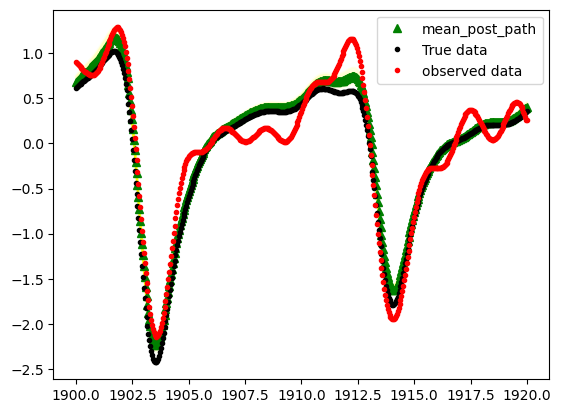

((2.190233958418216e+119, -1.8712066008578704e-61),
 array([-0.01743929,  0.60457827,  0.00190873, -0.44794728]),
 array([0.01222105, 0.02025172, 0.00413143, 0.01180791]))

In [115]:
# Use kde to create distribution of the observed data paths 
dim = 150 #(20)
method = 0.15# 'silverman', 'scott' (0.15)
x_kde_obs, indices = estimate_kde(x_noisy_paths, dim = dim, bw_method = method, idx = True) #compute kde
x_obs_densities = kde_density_at_points(x_kde_obs,x_noisy_paths, dim=dim) #estimate data densities

# set hyper parameers
num_prior = 5000
Normal = False

# generate prior samples by doing the following: You need to define this in a function
if Normal:    
    # Generate sample points from normal distribution
    print(f'Prior is generated from normal distribution')
    # Generate sample points from normal distribution 
    x_prior_param_mean = np.array([0, 0.55, 0, -0.455])
    x_prior_param_std = np.array([0.001, 0.2, 0.001, 0.2]) 
    
    # Generate samples from a normal distribution
    x_prior_param_samples = generate_samples(x_prior_param_mean, x_prior_param_std, num_prior, distribution='normal')
    if num_prior <=1000:
        x_prior_param_samples = expand_2D_array(x_prior_param_samples)
        print(f'Number of prior samples post-pairing = {len(x_prior_param_samples)}')
    # Use the function to generate different sample path
    x_pushforward_prior = gofx(x_prior_param_samples, library)
    print(f'mean:{x_prior_param_mean} , std:{x_prior_param_std} \n')  

else:
    # Generate sample points from uniform distribution
    print(f'Prior is generated from uniform distribution')
    x_prior_param_low =  np.array([-0.04, -1, -0.04, -1]) 
    x_prior_param_high = np.array([0.04, 1, 0.03, 1])
    # Generate samples from a uniform distribution
    x_prior_param_samples = generate_samples(x_prior_param_low, x_prior_param_high, num_prior, distribution='uniform')
    # param_pairs = expand_2D_array(obs_param_samples)
    if num_prior <=1000:
        x_prior_param_samples = expand_2D_array(x_prior_param_samples)
        print(f'Number of prior samples post-pairing = {len(x_prior_param_samples)}')
    # Use the function to generate different sample path
    x_pushforward_prior = gofx(x_prior_param_samples, library)
    print(f'low:{x_prior_param_low} , high:{x_prior_param_high}\n')


# use kde with similar parameter as in x_kde_obs to generate pushforward prior kde
x_kde_prior = estimate_kde(x_pushforward_prior, dim = dim, bw_method = method) #compute kde
# prior_densities = kde_density_at_points(x_kde_prior, x_pushforward_prior, dim=dim) #estimate data densities

#Run acceptance rejection sampling to generate posterior
x_post_param_samples = []
tym = 0
tym2 = 0
while len(x_post_param_samples)<50:
    # print(x_prior_param_samples[:5])
    if len(x_post_param_samples)<10:
        if Normal:
            x_prior_param_samples = generate_samples(x_prior_param_mean, x_prior_param_std, num_prior, distribution='normal')
        else: 
            x_prior_param_samples = generate_samples(x_prior_param_low, x_prior_param_high, num_prior, distribution='uniform')
        
        #spike and slab prior
        if ss_prior:
            x_prior_param_samples= ss_prior_fn(x_prior_param_samples, u_spike_prob)
        
        # run the acceptance rejection sampling algorithm
        x_post_param_samples.extend(rejection_sampling(x_prior_param_samples, gofx, x_kde_obs, x_kde_prior, library))
        print(f'at tym = {tym}, total samples accepted = {len(x_post_param_samples)} \n')
        tym += 1
        # print(x_post_param_samples)
        # temp = x_post_param_samples
    
        
    else:
        # Generate sample points from uniform distribution
        print(f'Prior is generated from uniform distribution')
        if tym2 == 0:        
            x_prior_param_low =  np.min(x_post_param_samples,0)  
            x_prior_param_high = np.max(x_post_param_samples,0)
            tym2 += 1
        else:
            x_prior_param_low =  np.min(x_post_param_samples,0)  
            x_prior_param_high = np.max(x_post_param_samples,0)
            tym2 += 1
            
        # Generate samples from a uniform distribution
        x_prior_param_samples = generate_samples(x_prior_param_low, x_prior_param_high, n_samples=1000, distribution='uniform')
        
        #spike and slab prior
        if ss_prior:
            x_prior_param_samples= ss_prior_fn(x_prior_param_samples, u_spike_prob)
        # Use the function to generate different sample path
        x_pushforward_prior = gofx(x_prior_param_samples, library)
        x_kde_prior = estimate_kde(x_pushforward_prior, dim = dim, bw_method = method) #compute kde
        
        print(f'low:{x_prior_param_low} , high:{x_prior_param_high}\n')
        temp = rejection_sampling(x_prior_param_samples, gofx, x_kde_obs, x_kde_prior, library)
        x_post_param_samples.extend(temp)
        print(f'at tym = {tym}, total samples accepted = {len(x_post_param_samples)} \n')
        tym+=1

x_post_param_samples = np.array(x_post_param_samples)
# Get the pushforward of posterior distribution of each parameter
print(f'Final total number of accepted samples = {len(x_post_param_samples)}')
x_pushforward_posterior = gofx(x_post_param_samples, library)

# compare the pushforward distribution to the observed data using visuals and kl divergence of the kde
# plot_paths(x_actual, observed_paths, color='blue', hl = 'r*',label = 'mean_obs_path')
for path in x_pushforward_posterior:
        plt.plot(t, path, color='yellow', alpha=0.05)  # semi-transparent blue lines
x_mean_path = np.mean(x_pushforward_posterior, axis=0)
plt.plot(t, x_mean_path, 'g^' , label='mean_post_path')
plt.plot(t, u_dot_true, 'k.', label = 'True data')
plt.plot(t, x_dot_noisy, 'r.', label = 'observed data')
plt.legend()
plt.show()

# kl divergence
kl_divs = kl_divergence(x_noisy_paths,x_pushforward_posterior, bandwidth=method )
kl_divs,np.mean(x_post_param_samples,0), np.std(x_post_param_samples,0)        

Data shape for KDE: (300, 150)
Prior is generated from uniform distribution
low:[-0.04 -0.04 -1.   -1.  ] , high:[0.04 0.04 1.   1.  ]

Data shape for KDE: (5000, 150)
prob-value = 1.0, accepted value = [-0.         -0.01428866 -0.83627061  0.52067065]

prob-value = 0.9926624086161283, accepted value = [-5.79992969e-05  2.31034721e-02 -8.99783946e-01  5.12446449e-01]

2 was accepted out of 5000 total prior samples
at tym = 0, total samples accepted = 2 

prob-value = 1.0, accepted value = [-0.         -0.         -0.86517699  0.53264332]

1 was accepted out of 5000 total prior samples
at tym = 1, total samples accepted = 3 

prob-value = 1.0, accepted value = [ 0.          0.         -0.8695137   0.51747808]

prob-value = 0.46166590513519185, accepted value = [ 0.          0.         -0.93035272  0.55622244]

2 was accepted out of 5000 total prior samples
at tym = 2, total samples accepted = 5 

prob-value = 1.0, accepted value = [-0.         -0.01927837 -0.91250868  0.56137835]

1 was

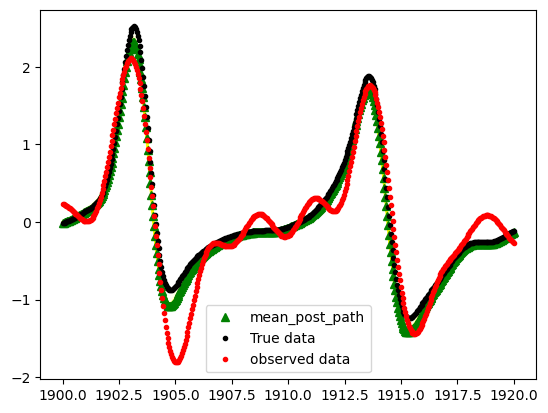

((2.1712221470850897e+121, -1.6430622895533575e-128),
 array([ 0.02176798,  0.00140394, -0.91056925,  0.53688676]),
 array([0.01468276, 0.00760486, 0.01592776, 0.00826986]))

In [116]:
# Use kde to create distribution of the observed data paths 
y_kde_obs, y_indx = estimate_kde(y_noisy_paths, dim = dim, bw_method = method, idx=True) #compute kde
y_obs_densities = kde_density_at_points(y_kde_obs,y_noisy_paths, dim=dim) #estimate data densities

# set hyper parameers
num_prior = 5000
# Normal = True

# generate prior samples by doing the following: You need to define this in a function
if Normal:    
    # Generate sample points from normal distribution
    print(f'Prior is generated from normal distribution')
    # Generate sample points from normal distribution 
    y_prior_param_mean = np.array( [0, 0, -0.84,0.5433])
    y_prior_param_std = np.array([0.02, 0.02,0.2,0.2]) 
    
    # Generate samples from a normal distribution
    y_prior_param_samples = generate_samples(y_prior_param_mean, y_prior_param_std, num_prior, distribution='normal')
    if num_prior <=1000:
        y_prior_param_samples = expand_2D_array(y_prior_param_samples)
        print(f'Number of prior samples post-pairing = {len(y_prior_param_samples)}')
    # Use the function to generate different sample path
    y_pushforward_prior = gofx(y_prior_param_samples, library)
    print(f'mean:{y_prior_param_mean} , std:{y_prior_param_std} \n')  

else:
    # Generate sample points from uniform distribution
    print(f'Prior is generated from uniform distribution')
    y_prior_param_low =  np.array([-0.04,-0.04, -1, -1]) 
    y_prior_param_high = np.array([0.04,0.04, 1, 1])
    # Generate samples from a uniform distribution
    y_prior_param_samples = generate_samples(y_prior_param_low, y_prior_param_high, num_prior, distribution='uniform')
    # param_pairs = expand_2D_array(obs_param_samples)
    if num_prior <=1000:
        y_prior_param_samples = expand_2D_array(y_prior_param_samples)
        print(f'Number of prior samples post-pairing = {len(y_prior_param_samples)}')
    # Use the function to generate different sample path
    y_pushforward_prior = gofx(y_prior_param_samples, library)
    print(f'low:{y_prior_param_low} , high:{y_prior_param_high}\n')


# use kde with similar parameter as in y_kde_obs to generate pushforward prior kde
y_kde_prior = estimate_kde(y_pushforward_prior, dim = dim, bw_method = method) #compute kde
# prior_densities = kde_density_at_points(y_kde_prior, y_pushforward_prior, dim=dim) #estimate data densities

#Run acceptance rejection sampling to generate posterior
y_post_param_samples = []
tym = 0
tym2 = 0
while len(y_post_param_samples)<100:
    if len(y_post_param_samples)<10:
        if Normal:
            y_prior_param_samples = generate_samples(y_prior_param_mean, y_prior_param_std, num_prior, distribution='normal')
        else:
            y_prior_param_samples = generate_samples(y_prior_param_low, y_prior_param_high, num_prior, distribution='uniform')
        
        #spike and slab prior
        if ss_prior:
            y_prior_param_samples= ss_prior_fn(y_prior_param_samples, v_spike_prob)
        # run the acceptance rejection sampling algorithm
        y_post_param_samples.extend(rejection_sampling(y_prior_param_samples, gofx, y_kde_obs, y_kde_prior, library))
        print(f'at tym = {tym}, total samples accepted = {len(y_post_param_samples)} \n')
        tym += 1
        # temp = y_post_param_samples
        
    else:
        # Generate sample points from uniform distribution
        print(f'Prior is generated from uniform distribution')
        if tym2 == 0:
            y_prior_param_low =  np.min(y_post_param_samples,0)
            y_prior_param_high = np.max(y_post_param_samples,0)
            tym2 += 1
        else:
            y_prior_param_low =  np.min(y_post_param_samples,0)  
            y_prior_param_high = np.max(y_post_param_samples,0)
            tym2 += 1
       
        # Generate samples from a uniform distribution
        y_prior_param_samples = generate_samples(y_prior_param_low, y_prior_param_high, n_samples=1000, distribution='uniform')
        
        #spike and slab prior
        if ss_prior:
            y_prior_param_samples= ss_prior_fn(y_prior_param_samples, v_spike_prob)
        # Use the function to generate different sample path
        y_pushforward_prior = gofx(y_prior_param_samples, library)
        y_kde_prior = estimate_kde(y_pushforward_prior, dim = dim, bw_method = method) #compute kde
        
        print(f'low:{y_prior_param_low} , high:{y_prior_param_high}\n')
        temp = rejection_sampling(y_prior_param_samples, gofx, y_kde_obs, y_kde_prior, library)
        y_post_param_samples.extend(temp)
        print(f'at tym = {tym}, total samples accepted = {len(y_post_param_samples)} \n')
        tym+=1

y_post_param_samples = np.array(y_post_param_samples)
# Get the pushforward of posterior distribution of each parameter
print(f'Final total number of accepted samples = {len(y_post_param_samples)}')
y_pushforward_posterior = gofx(y_post_param_samples, library)

# compare the pushforward distribution to the observed data using visuals and kl divergence of the kde
# plot_paths(y_actual, observed_paths, color='blue', hl = 'r*',label = 'mean_obs_path')
for path in y_pushforward_posterior:
        plt.plot(t, path, color='yellow', alpha=0.05)  # semi-transparent blue lines
y_mean_path = np.mean(y_pushforward_posterior, axis=0)
plt.plot(t, y_mean_path, 'g^' , label='mean_post_path')
plt.plot(t, v_dot_true, 'k.', label = 'True data')
plt.plot(t, y_dot_noisy, 'r.', label = 'observed data')
plt.legend()
plt.show()


# kl divergence
kl_divs = kl_divergence(y_noisy_paths,y_pushforward_posterior, bandwidth=method )
kl_divs,np.mean(y_post_param_samples,0), np.std(y_post_param_samples,0)        

## UQSINDy

In [122]:
# Initialize the parameters (params and sigma)
u_start_params = np.zeros(4) #calc_mean(chain_param_ltk.params) #
u_start_sigma = 0.01 #calc_mean(chain_eps_ltk.sigma) #
num_step = 150


u_Posterior_params = []
u_Posterior_sigma = []
# While the number of steps is less than a preset
step = 0
while step<num_step:
    if step%5 == 0:
        print(f'______________________________________________________________________{step}th iteration_________________________________________________________________')
    
    # Sample new params given sigma using ABC likelihood without gamma
    def log_likelihood(u_params):
        if ss_prior:
            u_params = ss_prior_fn(u_params, u_spike_prob)
        a,b,c,d = u_params
        sig = u_start_sigma
        
        # predict udot
        udot_predict = simulate_param(u_params, library).reshape(-1)
        
        model = smp.Model()
        # Log-likelihood
        model.add(smp.normal(udot_predict, mu=u_dot_noisy, sig=sig))   
    
        # log-priors
        model.add(smp.uniform(a, lower = -1, upper=1),
                  smp.uniform(b, lower = -1, upper=1),
                  smp.uniform(c, lower = -1 , upper=1),
                  smp.uniform(d, lower = -1, upper=1)
                 )
        return model()


    u_start_params_ltk = {'u_params': u_start_params} # Set the starting model parameter
    print(f'Params start = {u_start_params_ltk}') # Print the starting model parameter
    hmc_param_ltk = smp.Slice(log_likelihood, u_start_params_ltk)
    chain_param_ltk = hmc_param_ltk.sample(100, burn=50, n_chains=1)
    #Replace current with accepted params
    u_start_params = calc_mean(chain_param_ltk.u_params)
    
    
   
    # Sample new sigma given new params using sigma likelihood
    def sigma_likelihood(u_sigma):
        sig = u_sigma
        
        # predict udot
        udot_predict = simulate_param(u_start_params, library).reshape(-1)
        
        model = smp.Model()
        
        # Log-likelihood
        model.add(smp.normal(udot_predict, mu=u_dot_noisy, sig=sig))    
        # log-priors
        model.add(smp.exponential(sig))
        return model()
    
    #Sampling sigma given the parameters
    start_eps_ltk = {'u_sigma': u_start_sigma} # Set the starting sigma parameter
    print(f'sigma start = {start_eps_ltk}') # Print the starting sigma parameter
    hmc_eps_ltk = smp.NUTS(sigma_likelihood, start_eps_ltk) #Hamiltonian, Slice, NUTS, Metropolis
    chain_eps_ltk = hmc_eps_ltk.sample(100, burn=50, n_chains=1)
    u_start_sigma = calc_mean(chain_eps_ltk.u_sigma)
    
    # Store the new params and sigma
    u_Posterior_params.extend(chain_param_ltk.u_params)
    u_Posterior_sigma.extend(chain_eps_ltk.u_sigma)
    
    #Repeat step 3-5 
    step +=1
    # mean_params = start_params
    print(f'Recovered u_params = {u_start_params}')
    print(f'Recovered u_sigma = {u_start_sigma} \n\n')
    

______________________________________________________________________0th iteration_________________________________________________________________
Params start = {'u_params': array([0., 0., 0., 0.])}
Progress: [##############################] 100 of 100 samples
sigma start = {'u_sigma': 0.01}


C:\Users\USER\.conda\envs\sunode-env\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


Progress: [##############################] 100 of 100 samples
Recovered u_params = [ 0.09002458  0.59625345 -0.29672799 -0.4467645 ]
Recovered u_sigma = 0.4726903195660251 


Params start = {'u_params': array([ 0.09002458,  0.59625345, -0.29672799, -0.4467645 ])}
Progress: [##############################] 100 of 100 samples
sigma start = {'u_sigma': 0.4726903195660251}
Progress: [##############################] 100 of 100 samples
Recovered u_params = [-0.71165054  0.59203965 -0.28328324 -0.44265739]
Recovered u_sigma = 1.1167674167135093 


Params start = {'u_params': array([-0.71165054,  0.59203965, -0.28328324, -0.44265739])}
Progress: [##############################] 100 of 100 samples
sigma start = {'u_sigma': 1.1167674167135093}
Progress: [##############################] 100 of 100 samples
Recovered u_params = [-0.94894773  0.58452878 -0.21638958 -0.44229781]
Recovered u_sigma = 1.259397279993729 


Params start = {'u_params': array([-0.94894773,  0.58452878, -0.21638958, -0.44229

Exception: Slice sampler shrank to zero!

[-2.92046389  1.13605788  0.17538458 -0.35619355] 2.6530833984244513


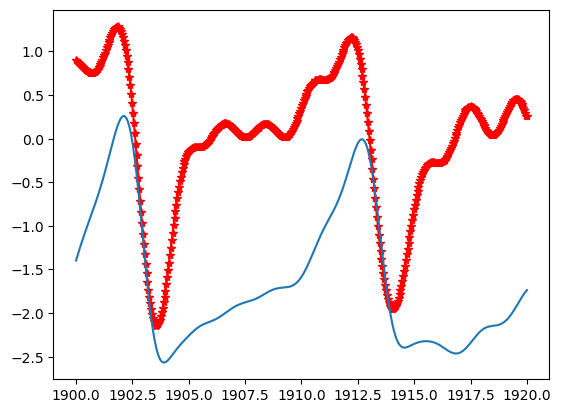

In [123]:
print(calc_mean(u_Posterior_params), calc_mean(u_Posterior_sigma))

u_dot_post = simulate_param(calc_mean(u_Posterior_params), library)
plt.plot(t, u_dot_noisy, 'r*-')
plt.plot(t, u_dot_post)
plt.show()

In [124]:
#spike and slab parameters
v_spike_prob=np.array([0.7,0.7,0.1,0.1])

# Initialize the parameters (params and sigma)
v_start_params = np.zeros(4) #calc_mean(chain_param_ltk.params) #
v_start_sigma = 0.2 #calc_mean(chain_eps_ltk.sigma) #
num_step = 50


v_Posterior_params = []
v_Posterior_sigma = []
# While the number of steps is less than a preset
step = 0
while step<num_step:
    if step%10 == 5:
        print(f'______________________________________________________________________{step}th iteration_________________________________________________________________')
    
    # Sample new params given sigma using ABC likelihood without gamma
    def log_likelihood(v_params):
        if ss_prior:
            v_params = ss_prior_fn(v_params, v_spike_prob)
        a,b,c,d = v_params
        sig = v_start_sigma
        
        # predict udot
        udot_predict = simulate_param(v_params, library).reshape(-1)
        
        model = smp.Model()
        # Log-likelihood
        model.add(smp.normal(udot_predict, mu=v_dot_noisy, sig=sig))   
    
        # log-priors
        model.add(smp.uniform(a, lower = -1, upper=1),
                  smp.uniform(b, lower = -1, upper=1),
                  smp.uniform(c, lower = -1 , upper=1),
                  smp.uniform(d, lower = -1 , upper=1)
                 )
        return model()


    v_start_params_ltk = {'v_params': v_start_params} # Set the starting model parameter
    print(f'Params start = {v_start_params_ltk}') # Print the starting model parameter
    hmc_param_ltk = smp.Slice(log_likelihood, v_start_params_ltk)
    chain_param_ltk = hmc_param_ltk.sample(100, burn=50, n_chains=1)
    #Replace current with accepted params
    v_start_params = calc_mean(chain_param_ltk.v_params)
    
    
   
    # Sample new sigma given new params using sigma likelihood
    def sigma_likelihood(v_sigma):
        sig = v_sigma
        
        # predict udot
        udot_predict = simulate_param(v_start_params, library).reshape(-1)
        
        model = smp.Model()
        
        # Log-likelihood
        model.add(smp.normal(udot_predict, mu=v_dot_noisy, sig=sig))    
        # log-priors
        model.add(smp.exponential(sig))
        return model()
    
    #Sampling sigma given the parameters
    start_eps_ltk = {'v_sigma': v_start_sigma} # Set the starting sigma parameter
    print(f'sigma start = {start_eps_ltk}') # Print the starting sigma parameter
    hmc_eps_ltk = smp.Slice(sigma_likelihood, start_eps_ltk) #Hamiltonian, Slice, NUTS, Metropolis
    chain_eps_ltk = hmc_eps_ltk.sample(100, burn=50, n_chains=1)
    v_start_sigma = calc_mean(chain_eps_ltk.v_sigma)
    
    # Store the new params and sigma
    v_Posterior_params.extend(chain_param_ltk.v_params)
    v_Posterior_sigma.extend(chain_eps_ltk.v_sigma)
    
    #Repeat step 3-5 
    step +=1
    # mean_params = start_params
    print(f'Recovered v_params = {v_start_params}')
    print(f'Recovered v_sigma = {v_start_sigma} \n\n')
    

Params start = {'v_params': array([0., 0., 0., 0.])}
Progress: [##############################] 100 of 100 samples
sigma start = {'v_sigma': 0.2}
Progress: [##############################] 100 of 100 samples
Recovered v_params = [-0.08012879  0.77830986 -0.89840489  0.53758189]
Recovered v_sigma = 1.4386858657471386 


Params start = {'v_params': array([-0.08012879,  0.77830986, -0.89840489,  0.53758189])}
Progress: [##############################] 100 of 100 samples
sigma start = {'v_sigma': 1.4386858657471386}
Progress: [##############################] 100 of 100 samples
Recovered v_params = [-1.00722424  2.24687024 -0.89901671  0.5435061 ]
Recovered v_sigma = 3.4981536897216334 


Params start = {'v_params': array([-1.00722424,  2.24687024, -0.89901671,  0.5435061 ])}
Progress: [##############################] 100 of 100 samples
sigma start = {'v_sigma': 3.4981536897216334}
Progress: [##############################] 100 of 100 samples
Recovered v_params = [-2.03285345  2.26400653 -0

[ 0.03304472  0.72405744 -0.86091574  0.51664098] 1.7695206856889694


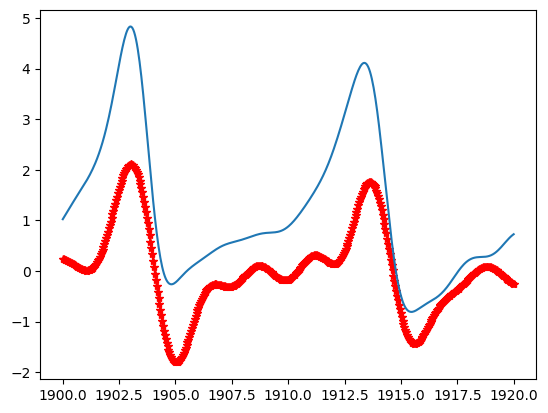

In [125]:
print(calc_mean(v_Posterior_params), calc_mean(v_Posterior_sigma))

v_dot_post = simulate_param(calc_mean(v_Posterior_params), library)
plt.plot(t, v_dot_noisy, 'r*-')
plt.plot(t, v_dot_post)
plt.show()

## Performance comparisons

In [117]:
def predict_lv_param(params):
    # Ensure params is a flat array or a tuple when passed to the integration function
    _, z_pred = integrate_lotka_volterra(t_span, z0, params, method='odeint', num_points=num_points)
    return z_pred

def lotka_volterra(t, z, a, b, g, d):
    u, v = z
    return [a*u + b*u*v, g*v + d*u*v]

def lotka_volterra_odeint(z, t, a, b, g, d):
    # No change needed here, but ensuring it's correctly defined    
    return [a*z[0] + b*z[0]*z[1], g*z[1] + d*z[0]*z[1]]

def integrate_lotka_volterra(t_span, z0, params, method='odeint', num_points=100):
    a, b, g, d = params
    # Convert params to their numerical values if they are ArrayBox instances
    # This step is crucial if params are wrapped by autograd for differentiation
    # Note: This simplification might not be directly applicable; it's illustrative
    numeric_params = [param if not isinstance(param, autograd.numpy.numpy_boxes.ArrayBox) else param._value for param in params]

    t_eval = np.linspace(*t_span, num_points)
    if method == 'solve_ivp':
        sol = solve_ivp(lambda t, z: lotka_volterra(t, z, *numeric_params), t_span, z0, t_eval=t_eval, method='RK45')
        z = sol.y
        t = sol.t
    elif method == 'odeint':
        sol = odeint(lotka_volterra_odeint, z0, t_eval, args=tuple(numeric_params))
        z = sol.T
        t = t_eval
    else:
        raise ValueError("Invalid method selected. Choose 'solve_ivp' or 'odeint'.")

    return t, z

In [119]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histograms_in_one(*matrices):
    """
    Plot histograms for columns of the given matrices. Each matrix must have the same number of columns
    but can have different number of rows.

    Parameters:
    *matrices (array-like): Variable number of matrices where each matrix is an array-like structure with
                            two dimensions. All matrices must have the same number of columns.

    Returns:
    None
    """
    # Ensure all matrices have the same number of columns
    if len(set(m.shape[1] for m in matrices)) != 1:
        raise ValueError("All matrices must have the same number of columns")
    
    num_columns = matrices[0].shape[1]
    num_rows = len(matrices)
    
    # Creating figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(5 * num_columns, 4), squeeze=False)
    axes = axes.flatten()  # Flatten the array of axes for easy iteration

    # For each column, plot the histogram across all matrices
    for col in range(num_columns):
        for idx, matrix in enumerate(matrices):
            column_data = matrix[:, col]
            mean_k = np.mean(column_data)
            sigma_k = np.std(column_data)
            
            # Plot histogram
            axes[col].hist(column_data, bins=20, alpha=0.7, density =True ,label=f'Matrix {idx+1} mean={mean_k:.2f}, $\sigma$={sigma_k:.2f}')
            
        # Set labels and titles
        axes[col].set_title(f'Column {col + 1}')
        axes[col].set_xlabel('Value')
        axes[col].set_ylabel('Frequency')
        axes[col].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()


def plot_matrix_histograms(*matrices, hist_labels = ['Observed data', 'SIP Posterior', 'PCE Posterior']):
    """
    Plots normalized histograms for each column of the given matrices. Each matrix is plotted
    in a separate figure with subplots arranged column-wise. Histograms are normalized so that
    they all have the same height scale (area under histogram equals 1).

    Parameters:
    *matrices (multiple numpy.ndarray arguments): matrices to plot with the same number of columns
    but possibly different number of rows.
    """
    for index, matrix in enumerate(matrices):
        num_columns = matrix.shape[1]
        fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(4*num_columns, 3), squeeze=False)
        fig.suptitle(f'{hist_labels[i]}', fontsize=16)
        
        for col in range(num_columns):
            ax = axes[0, col]
            data = matrix[:, col]
            mean_k = np.mean(data)
            std_k = np.std(data)
            ax.hist(data, bins='auto', color='skyblue', alpha=0.7, rwidth=0.85, density=True)
            ax.set_title(f'Param {col+1} (mean={mean_k:.2f}, std={std_k:.2f})')
            ax.set_xlabel('Value')
            ax.set_ylabel('Density')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for figure title
        plt.show()

def plot_matrix_histograms(*matrices, colors = ['red', 'blue', 'green'], hist_labels = ['Observed data', 'SIP Posterior', 'PCE Posterior']):
    """
    Plots normalized histograms for each column of the given matrices, with a vertical line indicating
    the mean of the samples. Each matrix is plotted in a separate figure with subplots arranged column-wise.
    Histograms are normalized so that they all have the same height scale (area under histogram equals 1).

    Parameters:
    *matrices (multiple numpy.ndarray arguments): matrices to plot with the same number of columns
    but possibly different number of rows.
    """
    for index, matrix in enumerate(matrices):
        num_columns = matrix.shape[1]
        fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(4*num_columns, 3), squeeze=False)
        fig.suptitle(f'{hist_labels[index]}', fontsize=16)
        
        for col in range(num_columns):
            ax = axes[0, col]
            data = matrix[:, col]
            mean_k = np.mean(data)
            std_k = np.std(data)
            # Create histogram with density=True to normalize heights
            ax.hist(data, bins='auto', color=colors[index], alpha=0.7, rwidth=0.85, density=True)
            # Plot a vertical line for the mean
            ax.axvline(mean_k, color='black', linestyle='dashed', linewidth=1)
            # Adding text annotation for mean
            # ax.text(mean_k, ax.get_ylim()[1] * 0.95, f'Mean: {mean_k:.2f}', color='black', ha='right')
            
            ax.set_title(f'Param {col+1} (mean={mean_k:.2f}, std={std_k:.2f})')
            ax.set_xlabel('Value')
            ax.set_ylabel('Density')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for figure title
        plt.show()

from scipy.stats import entropy

def plot_pushfowards(x_values, *y_paths_groups, show=False, colors=['red', 'blue', 'green'], hl='k*', labels=['Observed mean', 'SIP mean', 'PCE mean']):
    """
    Plots multiple groups of y paths (each group and each row in a group against x_values)
    on separate plots with a specified transparency. Computes the KL divergence of all groups
    with respect to the first group and displays it in the plot title.

    Parameters:
        x_values (array_like): The common x values for the y paths.
        *y_paths_groups (variable number of array_like arguments): Each being a matrix of y paths
            where each row in a matrix is a y path.
        show (bool): Whether to display the plot immediately.
        colors (list): List of colors for each group of paths.
        hl (str): Highlight style for the mean path.
        labels (list): Labels for the mean of each group.
    """
    if colors is None:
        colors = ['blue'] * len(y_paths_groups)
    if labels is None:
        labels = [f'mean_path_{i+1}' for i in range(len(y_paths_groups))]

    # Plot the means
    plt.figure(figsize=(10, 6))
    for index, y_paths in enumerate(y_paths_groups):        
        # Calculate the mean path across all rows (mean for each column)
        mean_path = np.mean(y_paths, axis=0)
        
        # Plot the mean path
        plt.plot(x_values, mean_path, color = colors[index], label=labels[index % len(labels)])  # mean path highlighted
        
    # Adding title and labels
    plt.title(f'Plots of Mean Paths')
    plt.xlabel('X Values')
    plt.ylabel('Y Values')
    plt.legend()
    plt.show()

    # Reference paths for KL divergence
    reference_y_paths = y_paths_groups[0]
    reference_density, _ = np.histogram(reference_y_paths, bins=30, density=True)
    
    for index, y_paths in enumerate(y_paths_groups):
        plt.figure(figsize=(10, 6))
        
        # Calculate the mean path across all rows (mean for each column)
        mean_path = np.mean(y_paths, axis=0)
        
        # Plot each path
        for path in y_paths:
            plt.plot(x_values, path, color=colors[index % len(colors)], alpha=0.3)  # semi-transparent lines
        
        # Plot the mean path
        plt.plot(x_values, mean_path, hl, label=labels[index % len(labels)])  # mean path highlighted
        
        # Compute and plot KL divergence with respect to the first group
        current_density, _ = np.histogram(y_paths, bins=30, density=True)
        kl_div = entropy(current_density, reference_density)
        
        # Adding title and labels
        plt.title(f'Plots of Paths (KL div w.r.t. first group: {kl_div:.2f})')
        plt.xlabel('X Values')
        plt.ylabel('Y Values')
        plt.legend()
        
        if show:
            plt.show()

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
   
def plot_kde_matrix(data, titles, color='orange', name='SIP method', xlim = (-2,2)):
    data = np.array(data)

    n, m = data.shape
    mn,mx = np.min(data)-0.05, np.max(data)+0.05
    if len(titles) != m:
        raise ValueError("Length of titles vector must be equal to the number of columns in data.")
    
    fig, axes = plt.subplots(m, 1, figsize=(2.5, 1.5 * m), sharex='col', gridspec_kw={'hspace': 0})
    for i in range(m):
        kde = gaussian_kde(data[:, i])
        x = np.linspace(min(data[:, i]), max(data[:, i]), 1000)
        # mn,mx = np.min(x)-0.05, np.max(x)+0.05
        axes[i].plot(x, kde(x), color=color)
        axes[i].fill_between(x, kde(x), color=color, alpha=0.5)
        mean_val = np.mean(data[:, i])
        axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'mean= {mean_val.round(2)}')
        axes[i].axvline(0, color='black', linestyle='-.')
        axes[i].set_xlim(mn,mx)
        axes[i].set_ylabel(titles[i], rotation=0, labelpad=40)
        # Position legend in the top right corner of each subplot
        axes[i].legend(loc='upper right', draggable = True)
        axes[i].yaxis.set_label_position("left")
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['bottom'].set_visible(True)
        axes[i].get_xaxis().set_visible(True)
        axes[i].tick_params(axis='x', which='both', bottom=True)
        axes[i].tick_params(axis='y', which='both', left=False, right=False)  # Remove vertical ticks
        axes[i].set_yticklabels([])  # Remove vertical tick labels
        
    plt.subplots_adjust(left=0.3)  # Adjust this as necessary to fit titles
    plt.xlabel('Value')  # Set common xlabel for the horizontal axis
    plt.suptitle(name)
    plt.show()

### Posterior distribution visualization

In [126]:
print(f' SIP  u_dot recovered distribution \n mean = {np.mean(x_post_param_samples,0).round(3)}, \n sigma = {np.std(x_post_param_samples,0).round(3)} \n')
print(f' Bayesian u_dot recovered distribution \n mean = {np.mean(u_Posterior_params,0).round(3)}, \n sigma = {np.std(u_Posterior_params,0).round(3)} \n\n\n')

print(f' SIP  v_dot recovered distribution \n mean = {np.mean(y_post_param_samples,0).round(3)}, \n sigma = {np.std(y_post_param_samples,0).round(3)} \n')
print(f' Bayesian v_dot recovered distribution \n mean = {np.mean(v_Posterior_params,0).round(3)}, \n sigma = {np.std(v_Posterior_params,0).round(3)} \n')

 SIP  u_dot recovered distribution 
 mean = [-0.017  0.605  0.002 -0.448], 
 sigma = [0.012 0.02  0.004 0.012] 

 Bayesian u_dot recovered distribution 
 mean = [-2.92   1.136  0.175 -0.356], 
 sigma = [2.922 0.797 1.014 0.153] 



 SIP  v_dot recovered distribution 
 mean = [ 0.022  0.001 -0.911  0.537], 
 sigma = [0.015 0.008 0.016 0.008] 

 Bayesian v_dot recovered distribution 
 mean = [ 0.033  0.724 -0.861  0.517], 
 sigma = [0.892 1.343 0.178 0.093] 



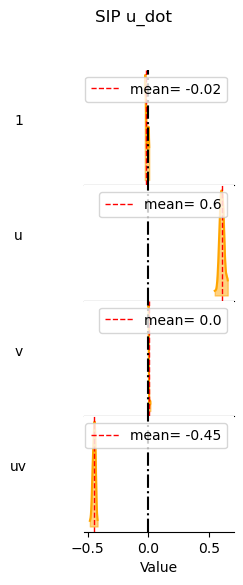

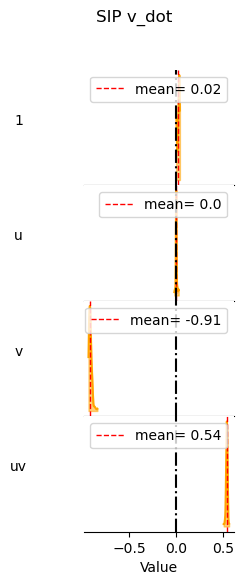

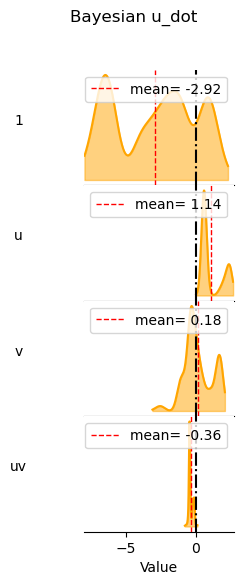

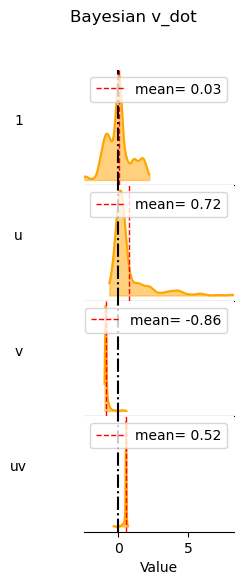

In [127]:
# SIP posterior distribution
titles = ['1', 'u', 'v', 'uv']
plot_kde_matrix(x_post_param_samples, titles, color='orange', name = 'SIP u_dot', xlim=(-1.5,1.5))

plot_kde_matrix(y_post_param_samples, titles, color='orange', name = 'SIP v_dot', xlim = (-3,3))


# UQ SINDy posterior distribtuion
titles = ['1', 'u', 'v', 'uv']
plot_kde_matrix(u_Posterior_params, titles, color='orange', name = 'Bayesian u_dot') # xlim=(-1.5,1.5))

plot_kde_matrix(v_Posterior_params, titles, color='orange', name = 'Bayesian v_dot') # xlim = (-3,3))

In [129]:
def sim_lynx_hare(params):
    a,b,g,d = params
    params = (a,b,d,g)
    solution = odeint(lotka_volterra_system, initial_state, time, args=params)
    u_sim, v_sim = solution.T
    u_sim,v_sim = u_sim*u_scale, v_sim*v_scale
    return u_sim, v_sim

def recovered_lv(state, t, u_params,v_params):
    u,v = state
    a0,b0,c0,d0 = u_params
    a1,b1,c1,d1 = v_params    
    du_dt = a0*1 + b0*u + c0*v + d0*u*v
    dv_dt = a1*1 + b1*u + c1*v + d1*u*v
    return [du_dt, dv_dt]

def simulate_recovered_params(u_params,v_params):
    solution = odeint(recovered_lv, initial_state, time, args=(u_params, v_params,))
    u_sim, v_sim = solution.T
    u_sim,v_sim = u_sim*u_scale, v_sim*v_scale
    return u_sim,v_sim

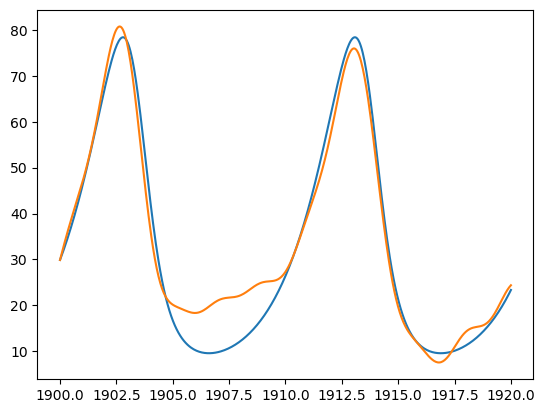

In [131]:
# true parameters
u_true = [0,0.55,0,-0.455]
v_true  = [0,0,-0.84,0.5433]
u_tmp, v_tmp = simulate_recovered_params(u_true,v_true)

# SIP posterior path plot
plt.plot(time, u_tmp)
plt.plot(time, u_data)
plt.show()

SIP u_mse = 99.11535280918686
SIP v_mse = 65.09043006480441


UQ u_mse = 3.5348482067462183e+28
UQ v_mse = 2039.6474628396659


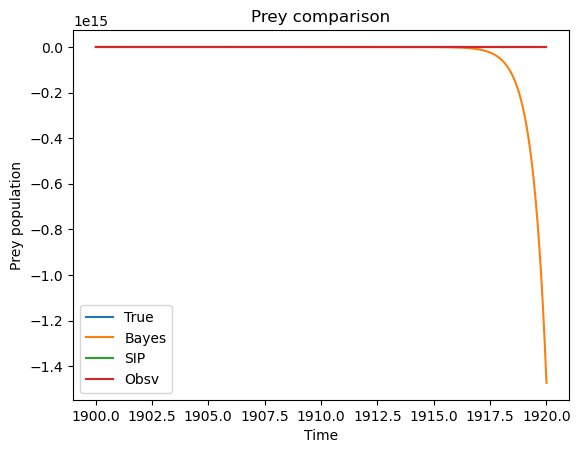

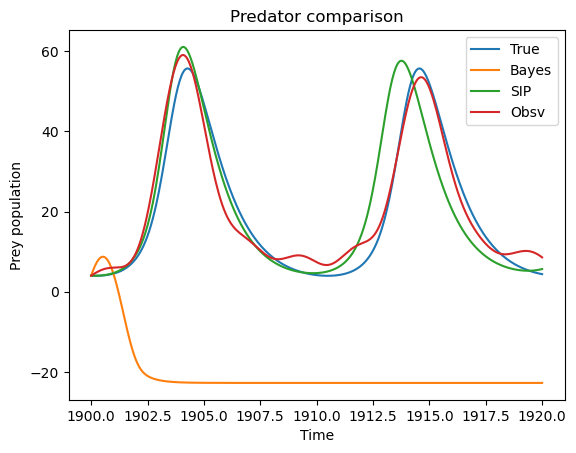

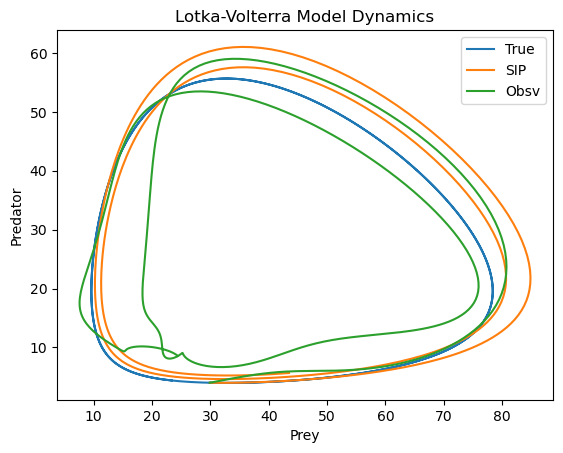

In [133]:
# SIP SINDy posterior simulation
u_postmean_sip = calc_mean(x_post_param_samples)
v_postmean_sip = calc_mean(y_post_param_samples)

u_post_sip, v_post_sip = simulate_recovered_params(u_postmean_sip,v_postmean_sip)
# u_post_sip, v_post_sip = u_post_sip*u_scale, v_post_sip*v_scale

print(f'SIP u_mse = {mean_squared_error(u_sim, u_post_sip)}')
print(f'SIP v_mse = {mean_squared_error(v_sim, v_post_sip)}\n\n')


# UQ SINDy posterior simulation
u_postmean_uq = calc_mean(u_Posterior_params)
v_postmean_uq = calc_mean(v_Posterior_params)

u_post_uq, v_post_uq = simulate_recovered_params(u_postmean_uq,v_postmean_uq)
# u_post_uq, v_post_uq = u_post_uq*u_scale, v_post_uq*v_scale

print(f'UQ u_mse = {mean_squared_error(u_sim, u_post_uq)}')
print(f'UQ v_mse = {mean_squared_error(v_sim, v_post_uq)}')


# plot and compare simulation versus observed data
plt.figure()
plt.title('Prey comparison')
plt.plot(t, u_sim, label='True')
plt.plot(t, u_post_uq, label='Bayes')
plt.plot(t, u_post_sip, label='SIP')
plt.plot(t, u_data, label='Obsv')
plt.xlabel('Time')
plt.ylabel('Prey population')
plt.legend()
plt.show()

plt.figure()
plt.title('Predator comparison')
plt.plot(t, v_sim, label='True')
plt.plot(t, v_post_uq, label='Bayes')
plt.plot(t, v_post_sip, label='SIP')
plt.plot(t, v_data, label='Obsv')
plt.xlabel('Time')
plt.ylabel('Prey population')
plt.legend()
plt.show()

plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
plt.plot(u_sim, v_sim, label='True')
# plt.plot(u_post_uq, v_post_uq, label='Bayes')
plt.plot(u_post_sip, v_post_sip, label='SIP')
plt.plot(u_data, v_data, label='Obsv')
plt.xlabel('Prey')
plt.ylabel('Predator')
plt.legend()
plt.show()

In [134]:
# true parameters
u_true = [0,0.55,0,-0.455]
v_true  = [0,0,-0.84,0.5433]

# mean path (mp) recovery
u_sip_mp = u_postmean_sip#[-0.0, 0.55, 0.0, -0.41]
u_bayes_mp  = u_postmean_uq#[-0.06, 0.59, 0.07, -0.46]

v_sip_mp  = v_postmean_sip #[0.02, 0.06, -0.84, 0.47]
v_bayes_mp  = v_postmean_uq #[0.04, 0.0, -0.91, 0.53]

u_recv_params = [u_sip_mp, u_bayes_mp, v_sip_mp, v_bayes_mp]
true_params = [u_true,u_true,v_true,v_true]
u_names = ['u_sip_mp', 'u_bayes_mp', 'v_sip_mp', 'v_bayes_mp']
for i,u_rcv in enumerate(u_recv_params):
    print(f'MSE {u_names[i]} = {np.sqrt(mean_squared_error(true_params[i], u_rcv)).round(5)}')

MSE u_sip_mp = 0.02888
MSE u_bayes_mp = 1.49274
MSE v_sip_mp = 0.03707
MSE v_bayes_mp = 0.3628


In [135]:
from tqdm import tqdm
# SIP posterior path simulation
u_sip_post_paths = []
v_sip_post_paths = []
lent = min(len(x_post_param_samples), len(y_post_param_samples), 300)
for i in tqdm(range(lent)):
    u_param_i = x_post_param_samples[i]
    v_param_i = y_post_param_samples[i]
    u_tmp, v_tmp = simulate_recovered_params(u_param_i,v_param_i)
    if mean_squared_error(u_sim, u_tmp) <= 2000:
        u_sip_post_paths.append(u_tmp)
    if mean_squared_error(v_sim, v_tmp) <= 2000:
        v_sip_post_paths.append(v_tmp)
        
u_sip_post_paths = np.array(u_sip_post_paths)
v_sip_post_paths = np.array(v_sip_post_paths)

# Bayes posterior path simulation
u_uq_post_paths = []
v_uq_post_paths = []
lent = min(len(u_Posterior_params), len(v_Posterior_params), 300)
for i in tqdm(range(lent)):
    u_param_i = u_Posterior_params[i]
    v_param_i = v_Posterior_params[i]
    u_tmp, v_tmp = simulate_recovered_params(u_param_i,v_param_i)
    if mean_squared_error(u_sim, u_tmp) <= 2000:
        u_uq_post_paths.append(u_tmp)
    if mean_squared_error(v_sim, v_tmp) <= 2000:
        v_uq_post_paths.append(v_tmp)
u_uq_post_paths=np.array(u_uq_post_paths)
v_uq_post_paths=np.array(v_uq_post_paths)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:07<00:00, 39.32it/s]


SIP u_mse = 8.453946203749398
SIP v_mse = 6.890161849989079


UQ u_mse = 30.557384886313507
UQ v_mse = 22.21252945699476


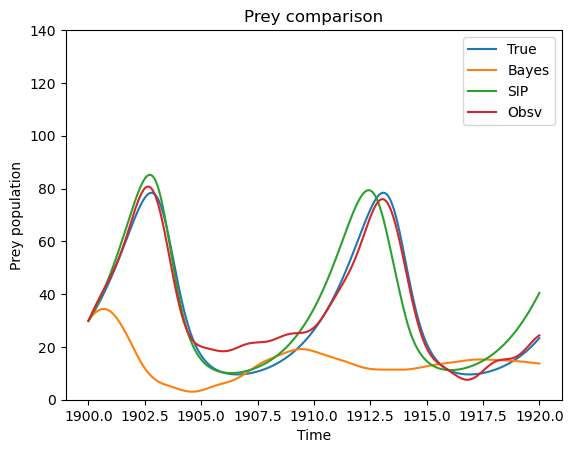

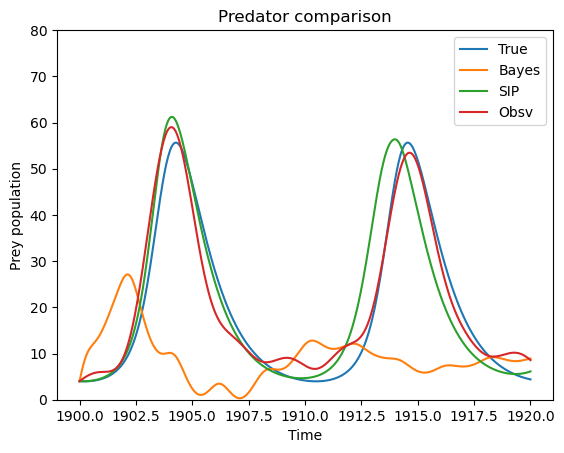

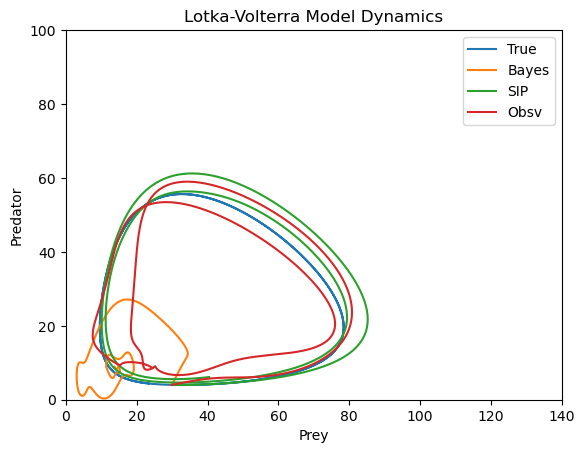

In [136]:
u_post_meanpath_sip = np.mean(u_sip_post_paths,0)
v_post_meanpath_sip = np.mean(v_sip_post_paths,0)

u_post_meanpath_uq = np.mean(u_uq_post_paths,0)
v_post_meanpath_uq = np.mean(v_uq_post_paths,0)

print(f'SIP u_mse = {np.sqrt(mean_squared_error(u_sim, u_post_meanpath_sip))}')
print(f'SIP v_mse = {np.sqrt(mean_squared_error(v_sim, v_post_meanpath_sip))}\n\n')

print(f'UQ u_mse = {np.sqrt(mean_squared_error(u_sim, u_post_meanpath_uq))}')
print(f'UQ v_mse = {np.sqrt(mean_squared_error(v_sim, v_post_meanpath_uq))}')


# plot and compare simulation versus observed data
plt.figure()
plt.title('Prey comparison')
plt.plot(t, u_sim, label='True')
plt.plot(t, u_post_meanpath_uq, label='Bayes')
plt.plot(t, u_post_meanpath_sip, label='SIP')
plt.plot(t, u_data, label='Obsv')
plt.xlabel('Time')
plt.ylabel('Prey population')
plt.ylim(0,140)
plt.legend()
plt.show()

plt.figure()
plt.title('Predator comparison')
plt.plot(t, v_sim, label='True')
plt.plot(t, v_post_meanpath_uq, label='Bayes')
plt.plot(t, v_post_meanpath_sip, label='SIP')
plt.plot(t, v_data, label='Obsv')
plt.xlabel('Time')
plt.ylabel('Prey population')
plt.ylim(0,80)
plt.legend()
plt.show()

plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
plt.plot(u_sim, v_sim, label='True')
plt.plot(u_post_meanpath_uq, v_post_meanpath_uq, label='Bayes')
plt.plot(u_post_meanpath_sip, v_post_meanpath_sip, label='SIP')
plt.plot(u_data, v_data, label='Obsv')
plt.xlabel('Prey')
plt.ylabel('Predator')
plt.ylim(0,100)
plt.xlim(0,140)
plt.legend()
plt.show()

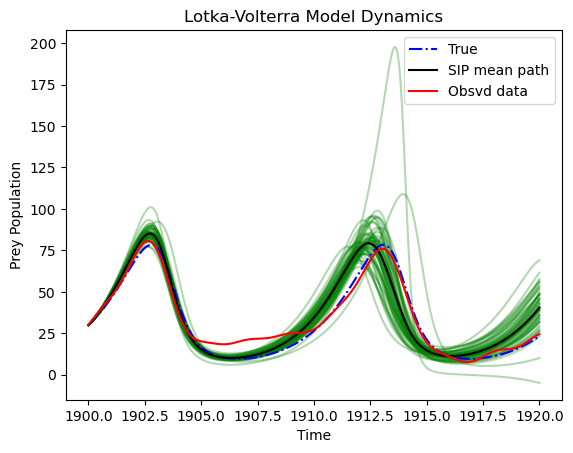

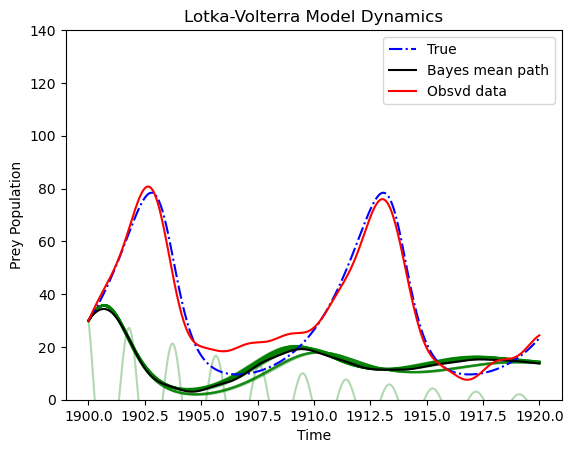

In [137]:
# Visualize paths
plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
for i in range(len(u_sip_post_paths)):
    xn = u_sip_post_paths[i]
    plt.plot(t, xn, 'g', alpha = 0.3)
plt.plot(t, u_sim, 'b-.', label='True')
plt.plot(t, u_post_meanpath_sip, 'k-', label='SIP mean path')
plt.plot(t, u_data, 'r-',label='Obsvd data')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Prey Population')
plt.legend()
plt.show()

# Visualize paths
plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
for i in range(len(u_uq_post_paths)):
    xn = u_uq_post_paths[i]
    plt.plot(t, xn, 'g', alpha = 0.3)
plt.plot(t, u_sim, 'b-.', label='True')
plt.plot(t, u_post_meanpath_uq, 'k-', label='Bayes mean path')
plt.plot(t, u_data, 'r-',label='Obsvd data')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Prey Population')
plt.ylim(0, 140)
plt.legend()
plt.show()

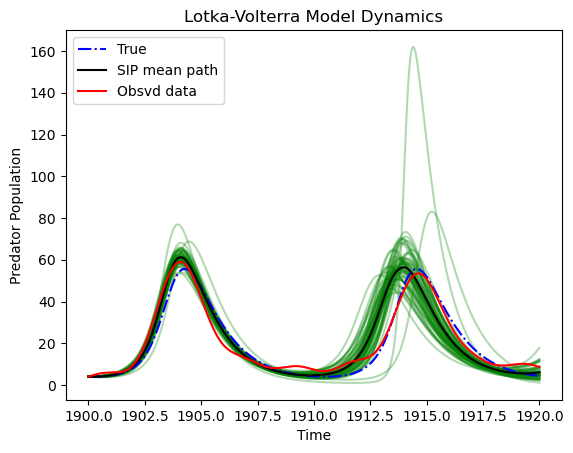

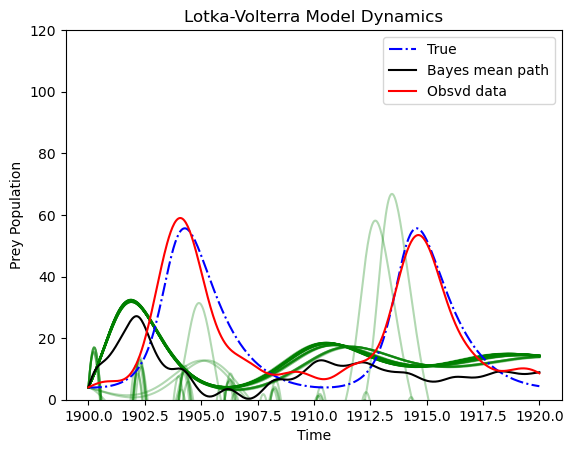

In [138]:
# Visualize paths
plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
for i in range(len(v_sip_post_paths)):
    yn = v_sip_post_paths[i]
    plt.plot(t, yn, 'g', alpha = 0.3)
plt.plot(t, v_sim, 'b-.', label='True')
plt.plot(t, v_post_meanpath_sip, 'k-', label='SIP mean path')
plt.plot(t, v_data, 'r-',label='Obsvd data')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Predator Population')
plt.legend()
plt.show()

# Visualize paths
plt.figure()
plt.title('Lotka-Volterra Model Dynamics')
for i in range(len(v_uq_post_paths)):
    yn = v_uq_post_paths[i]
    plt.plot(t, yn, 'g', alpha = 0.3)
plt.plot(t, v_sim, 'b-.', label='True')
plt.plot(t, v_post_meanpath_uq, 'k-', label='Bayes mean path')
plt.plot(t, v_data, 'r-',label='Obsvd data')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Prey Population')
plt.ylim(0, 120)
plt.legend()
plt.show()